In [1]:
import hickle
import pandas as pd
import scipy.signal
import shap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.table import Table
from scipy import ndimage
from tqdm import tqdm
import seaborn as sns
import dense_basis as db

import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models

import sklearn
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from PIL import Image as image_PIL
from PIL import Image, ImageOps
import PIL
from PIL import ImageShow
from astropy.io import fits

work_dir = '/home/juanpabloalfonzo/Documents/Manga CNNs/'

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
running without emcee


In [4]:
filepath = '/home/juanpabloalfonzo/Documents/Manga CNNs/Catalogues/Alfonzo_SFH_Morph_Table'
d = hickle.load(filepath)
manga_scalars = pd.DataFrame(d)
manga_scalars

,mangaid,RA_Pipe3D,DEC_Pipe3D,RA_gz,DEC_gz,log_mstar,log_sfr,t50_model
0,1-1009,149.647481,0.742773,0.064825,2080.0,11.178438,1.495913,9.326651
1,1-10166,199.295557,0.913561,0.080584,1040.0,11.513323,1.304750,11.744946
2,1-10177,199.460009,0.349990,0.048429,2336.0,10.615028,-1.669238,3.695137
3,1-10263,200.400259,0.573032,0.020133,1168.0,9.305632,-0.712431,11.957582
4,1-1033,149.707718,0.836658,0.012681,1168.0,9.172108,-1.427103,9.217347
...,...,...,...,...,...,...,...,...
10076,12-84677,232.158069,42.442017,0.075096,2.0,11.367102,-0.441849,3.918420
10077,12-84679,232.013865,42.813673,0.091575,2.0,11.426509,-1.152352,4.073496
10078,12-84726,231.577323,41.294630,NaN,NaN,9.285177,-0.850954,12.131769
10079,12-84731,232.461058,42.628968,0.018739,8192.0,10.012361,-0.123775,12.130999


In [3]:
filepath = work_dir+'Catalogues/scalars.cat'
d = hickle.load(filepath)
manga_scalars = pd.DataFrame(d)
manga_scalars

,mangaid,log_mstar,log_sfr,redshift,redshift_gz,sersic_n,t50_Pipe3D,t50_model,d4000,Av,...,smooth,merger_gz,p_merger,over_density,z_completeness,split,pred_mstar,pred_sfr,pred_d4000,sfh
0,1-1009,11.178438,1.495913,0.064825,0.184862,1.611328,8.877647,9.326651,1.230853,0.686813,...,0.268,0.000000,NaN,NaN,66.667000,Train,11.189139,1.439512,1.324850,"[[0.0, 0.012615064327869829, 0.025230128655739..."
1,1-10166,11.513323,1.304750,0.080584,0.090679,1.575562,7.787529,11.744946,1.324540,0.507066,...,1.000,0.000000,NaN,NaN,83.333000,Train,11.126817,1.155431,1.386914,"[[0.0, 0.012416507192248781, 0.024833014384497..."
2,1-10177,10.615028,-1.669238,0.048429,0.191842,2.399448,6.001504,3.695137,1.736577,0.198316,...,0.333,0.061335,NaN,NaN,60.784000,Train,10.297707,-1.271890,1.715749,"[[0.0, 0.012826418133447521, 0.025652836266895..."
3,1-10263,9.305632,-0.712431,0.020133,0.147054,1.085304,4.886795,11.957582,1.181307,0.117113,...,0.116,0.000000,NaN,NaN,18.570999,Train,9.894065,-0.861873,1.178038,"[[0.0, 0.013203016973830754, 0.026406033947661..."
4,1-1033,9.172108,-1.427103,0.012681,0.325117,0.792169,8.544791,9.217347,1.267143,0.129239,...,0.438,0.000000,NaN,NaN,2.293000,Train,9.438260,-1.006881,1.327091,"[[0.0, 0.013304768152224221, 0.026609536304448..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10076,12-84677,11.367102,-0.441849,0.075096,0.069899,3.079860,6.185514,3.918420,1.667887,0.103500,...,0.128,0.000000,NaN,1.479108,50.000000,Test,10.949705,-0.707256,1.739986,"[[0.0, 0.012485146405265527, 0.024970292810531..."
10077,12-84679,11.426509,-1.152352,0.091575,0.102585,6.000000,6.128925,4.073496,1.728466,NaN,...,0.095,0.000000,NaN,0.687470,38.095001,Test,11.471184,-1.803857,1.764508,"[[0.0, 0.012280612912046908, 0.024561225824093..."
10078,12-84726,9.285177,-0.850954,0.030912,NaN,1.074790,3.736318,12.131769,1.260653,0.125995,...,NaN,NaN,NaN,-0.186815,13.158000,Test,9.501426,-0.948579,1.237743,"[[0.0, 0.013057742998512816, 0.026115485997025..."
10079,12-84731,10.012361,-0.123775,0.018739,0.186415,0.931124,4.177648,12.130999,1.305303,0.269263,...,0.889,0.000000,NaN,42.730384,23.774000,Test,10.324865,-0.188354,1.454256,"[[0.0, 0.013221974396366389, 0.026443948792732..."


In [11]:
filepath = work_dir + 'Catalogues/images.cat'
d_im = hickle.load(filepath)
filepath = work_dir + 'Catalogues/shap_mass.cat'
d_shapmass = hickle.load(filepath)
filepath = work_dir + 'Catalogues/shap_sfr.cat'
d_shapsfr = hickle.load(filepath)
filepath = work_dir + 'Catalogues/shap_d4000.cat'
d_shapage = hickle.load(filepath)

In [12]:
def resize_image(src_image, size=(256,256), bg_color="black"): 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

def load_image_data(idlist, size=(256,256), bg_color="black"):
    
    images = []
    for gal_id in tqdm(idlist):
        #img = plt.imread('images/'+gal_id+'.png')
        img = Image.open(work_dir+'images (DR17)/'+gal_id+'.png')
        img_sized = resize_image(img, size=size, bg_color=bg_color)
        images.append(img_sized)
    return images

class MaNGAdataset(Dataset):
    """images and labels for CNN"""
    
    def __init__(self, manga_cat, galmask, transform = None):
        
        gal_ids = manga_cat['manga_id']
        gal_ids = np.array(gal_ids,dtype=str)[galmask]
        gal_mass = manga_cat['log_mstar'][galmask]
        #gal_mass_scaled = (gal_mass - 9)/4
        gal_mass_scaled = gal_mass
        gal_sfr = manga_cat['log_sfr'][galmask]
        gal_z = manga_cat['redshift'][galmask]
        gal_n = manga_cat['sersic_n'][galmask]
        gal_t50_pipe3d = np.log10(manga_cat['t50_pipe3d'])[galmask]
        gal_t50_model = np.log10(manga_cat['t50_model'])[galmask]
        gal_d4000 = manga_cat['d4000'][galmask]
        gal_spirals = manga_cat['spirals'][galmask]
        gal_bars = manga_cat['bars'][galmask]
        gal_bulge = manga_cat['bulge'][galmask]
        gal_edge_on = manga_cat['edge_on'][galmask]
        gal_irregular_features = manga_cat['irregular_features'][galmask]

        # good_index = np.where(gal_sfr != -np.inf)[0]
        good_index = np.where(np.array(gal_d4000,dtype=str) != 'nan')[0] #cleaning out nan values of d4000 

        gal_ids = gal_ids[good_index]
        gal_mass = gal_mass[good_index]
        gal_sfr = gal_sfr[good_index]
        gal_z = gal_z[good_index]
        gal_n = gal_n[good_index]
        gal_t50_pipe3d = gal_t50_pipe3d[good_index]
        gal_t50_model = gal_t50_model[good_index]
        gal_d4000 = gal_d4000[good_index]
        gal_spirals = gal_spirals[good_index]
        gal_bulge = gal_bulge[good_index]
        gal_bars = gal_bars[good_index]
        gal_edge_on = gal_edge_on[good_index]
        gal_irregular_features = gal_irregular_features[good_index]


        ###########CLASSIC CLASSES#######################

        bars=np.linspace(np.min(gal_sfr), np.max(gal_sfr), num=11) #Number of classes set here (+1), default was 20 
        sfr_cat = np.zeros_like(gal_sfr)
        for i in range(len(bars)-1):
            sfr_cat[(gal_sfr > bars[i]) & (gal_sfr < bars[i+1])]=int(i)
        sfr_cat[gal_sfr > bars[len(bars)-1]] = int(len(bars)-1)

        ########################NEW MORE EVENLY DISTRIBUTED CLASSES###################
        
        # bars=[-6,-2.5,-2,-1.7,-1.5,-1.2,-0.9,-0.7,-0.4,-0.1,0.1,0.9]
        # sfr_cat = np.zeros_like(gal_sfr)
        # for i in range(len(bars)-1):
        #     sfr_cat[(gal_sfr > bars[i]) & (gal_sfr < bars[i+1])]=int(i)
        # sfr_cat[gal_sfr > bars[len(bars)-1]] = int(len(bars)-1)
      
        self.image = load_image_data(gal_ids)
        self.mangaid = gal_ids
        self.mstar = gal_mass
        self.mstar_class = gal_mass
        self.sfr = sfr_cat
        self.z = gal_z
        self.n = gal_n
        #self.c = ((gal_mass - 6)*3 - 1).astype(int)
        self.c = sfr_cat.astype(int)
        self.transform = transform
        self.sfr_value = gal_sfr
        self.t50_pipe3d = gal_t50_pipe3d
        self.t50_model = gal_t50_model
        self.d4000 = gal_d4000
        self.spirals=gal_spirals
        self.bars = gal_bars
        self.bulge = gal_bulge
        self.edge_on = gal_edge_on
        self.irregular_features = gal_irregular_features

        
    def __len__(self):
        return len(self.mstar)
    
    def __getitem__(self, idx):
    
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = {'image': self.image[idx],
                'mass': self.mstar[idx],
                'z':self.z[idx],
                'n':self.n[idx],
                'sfr_class':self.sfr[idx],
                'mangaid':self.mangaid[idx],
                'sfr':self.sfr_value[idx],
                't50_pipe3d':self.t50_pipe3d[idx],
                't50_model':self.t50_model[idx],
                'd4000':self.d4000[idx],
                'spirals':self.spirals[idx],
                'bars':self.bars[idx],
                'bulge':self.bulge[idx],
                'edge_on':self.edge_on[idx],
                'irregular_features':self.irregular_features[idx]}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])

            
            
        return sample

In [13]:
train_loader = hickle.load(work_dir+'dataloaders/Train_Manga_DR17_Morph_for_SHAP_MAPS')
val_loader = hickle.load(work_dir+'dataloaders/Test_Manga_DR17_Morph_for_SHAP_MAPS')

In [14]:
batch_size=32

train_ids=[]
mass=[]
sfr=[]
t50=[]
images=[]
z=[]
t50_model =[]

data_sample=train_loader

for batch_idx, temp in enumerate(data_sample):
  train_ids.append(temp['mangaid'])
  mass.append(temp['mass'])
  sfr.append(temp['sfr'])
  t50.append(temp['d4000'])
  images.append(temp['image'])
  z.append(temp['z'])
  t50_model.append(temp['t50_model'])


incomplete_batch_id=len(train_ids)-1

remainder=len(train_ids[incomplete_batch_id])

total_values=(len(train_ids)*batch_size)-(batch_size-remainder)



train_ids_list=[]
train_mass_list=[]
train_sfr_list=[]
train_t50_list=[]
train_images_list=[]
train_z_list=[]
train_t50_model_list=[]
k=0
while k < total_values:
    for i in range(len(train_ids)):
        if i<incomplete_batch_id:
            for j in range(batch_size):
                train_ids_list.append(train_ids[i][j])
                train_mass_list.append(mass[i][j])
                train_sfr_list.append(sfr[i][j])
                train_t50_list.append(t50[i][j])
                train_images_list.append(images[i][j])
                train_z_list.append(z[i][j])
                train_t50_model_list.append(t50_model[i][j])
                k=k+1
        else:
            i=incomplete_batch_id
            for j in range(remainder):
                train_ids_list.append(train_ids[i][j])
                train_mass_list.append(mass[i][j])
                train_sfr_list.append(sfr[i][j])
                train_t50_list.append(t50[i][j])
                train_images_list.append(images[i][j])
                train_z_list.append(z[i][j])
                train_t50_model_list.append(t50_model[i][j])
                k=k+1

In [15]:
batch_size=32

val_ids=[]
mass=[]
sfr=[]
t50=[]
images=[]
z=[]
t50_model=[]

data_sample=val_loader

for batch_idx, temp in enumerate(data_sample):
  val_ids.append(temp['mangaid'])
  mass.append(temp['mass'])
  sfr.append(temp['sfr'])
  t50.append(temp['d4000'])
  images.append(temp['image'])
  z.append(temp['z'])
  t50_model.append(temp['t50_model'])


incomplete_batch_id=len(val_ids)-1

remainder=len(val_ids[incomplete_batch_id])

total_values=(len(val_ids)*batch_size)-(batch_size-remainder)



test_ids_list=[]
test_mass_list=[]
test_sfr_list=[]
test_t50_list=[]
test_images_list=[]
test_z_list=[]
test_t50_model_list=[]
k=0
while k < total_values:
    for i in range(len(val_ids)):
        if i<incomplete_batch_id:
            for j in range(batch_size):
                test_ids_list.append(val_ids[i][j])
                test_mass_list.append(mass[i][j])
                test_sfr_list.append(sfr[i][j])
                test_t50_list.append(t50[i][j])
                test_images_list.append(images[i][j])
                test_z_list.append(z[i][j])
                test_t50_model_list.append(t50_model[i][j])
                k=k+1
        else:
            i=incomplete_batch_id
            for j in range(remainder):
                test_ids_list.append(val_ids[i][j])
                test_mass_list.append(mass[i][j])
                test_sfr_list.append(sfr[i][j])
                test_t50_list.append(t50[i][j])
                test_images_list.append(images[i][j])
                test_z_list.append(z[i][j])
                test_t50_model_list.append(t50_model[i][j])
                k=k+1

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import dense_basis as db
db.sns.set(font_scale=2.5)
db.sns.set_style('ticks')

In [ ]:
def get_xax(z, nspaxels = 179):
    """
    Convert angular separation to physical distance at a given redshift (z)
    
    """
    spaxel_size = 0.5  # [arcsec]
    c = 299792  # speed of light [km/s]
    H0 = 70  # [km s^-1 Mpc^-1]
    D = c * z / H0  # a
    scale = 1 / 206265 * D * 1e6  # 1 radian = 206265 arcsec [pc / arcsec]
#     spaxel_area = (scale * spaxel_size)**2  # [pc^2]
    return np.arange(nspaxels) * (scale*spaxel_size) / 1e3 # return in kpc

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    from: https://github.com/mkolopanis/python/blob/master/radialProfile.py 

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

def calculate_average_across_arrays(array_of_arrays):
    # Determine the number of arrays
    num_arrays = len(array_of_arrays)

    # Determine the length of each array
    array_length = len(array_of_arrays[0])

    # Create an empty array to store the averages
    averages = []

    # Iterate over the indices of the sub-arrays
    for i in range(array_length):
        # Initialize a sum for the current index
        total = 0
        # Iterate over the sub-arrays and sum the values at the current index
        for j in range(num_arrays):
            total += array_of_arrays[j][i]
        # Calculate the average for the current index and append to the 'averages' array
        avg = total / num_arrays
        averages.append(avg)

    return averages

def calculate_median_across_arrays(array_of_arrays):
    # Determine the length of each array
    array_length = len(array_of_arrays[0])

    # Create an empty array to store the medians
    medians = []

    # Iterate over the indices of the sub-arrays
    for i in range(array_length):
        # Get the values at the current index across the sub-arrays
        values_at_index = [arr[i] for arr in array_of_arrays]
        # Calculate the median for the current index and append to the 'medians' array
        median = statistics.median(values_at_index)
        medians.append(median)

    return medians

def make_radial_shapplot(mv, massbins, clabel, 
                         zbin = 0.02, zbw = 0.01, mbw = 0.5):
    
    zv = manga_scalars['redshift']
    colors = cm.Spectral(np.linspace(0,1,len(massbins)))

    fig, ax = plt.subplots(1,3, figsize=(21,9))
    plt.subplot(1,3,1)
    plt.axhline(0,color='k',alpha=0.3)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(get_xax(0.02), np.nanmedian(mass_avgs[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (M$_*$)',fontsize=14)
    plt.xlim(1e-1,0.4e2)

    plt.subplot(1,3,2)
    plt.axhline(0,color='k',alpha=0.3)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(get_xax(0.02), np.nanmedian(sfr_avgs[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (SFR)',fontsize=14)
    plt.xlim(1e-1,0.4e2)

    plt.subplot(1,3,3)
    plt.axhline(0,color='k',alpha=0.3)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(get_xax(0.02), np.nanmedian(d4000_avgs[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (d4000)',fontsize=14)
    plt.xlim(1e-1,0.4e2)
    ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2g'))

    # ----------------------------------------------------------
    im1 = plt.scatter(massbins*1000, np.zeros_like(massbins), c=massbins, cmap='Spectral')
    axins1 = inset_axes(
        ax[2],
        width="70%",  # width: 50% of parent_bbox width
        height="2%",  # height: 5%
        loc="upper right", borderpad=1.2
    )
    axins1.xaxis.set_ticks_position("both")
    clbr = fig.colorbar(im1, cax=axins1, orientation="horizontal")
    clbr.set_label(clabel)
    plt.tight_layout()
    plt.show()

def SFH_plot(bins,target):
    num_bins = len(bins)
    colors = cm.Spectral(np.linspace(0,1,len(bins)))
    bin_indices = []
    
    if target == 'ssfr':
        for i in range(num_bins - 1):
            lower_bound = bins[i]
            upper_bound = bins[i + 1]
            
            bin_index = np.where(
                (np.array(manga_scalars['log_sfr']-manga_scalars['log_mstar']) > lower_bound) &
                (np.array(manga_scalars['log_sfr']-manga_scalars['log_mstar']) <= upper_bound)
            )[0]
            
            bin_indices.append(bin_index)

    else:
        for i in range(num_bins - 1):
            lower_bound = bins[i]
            upper_bound = bins[i + 1]
            
            bin_index = np.where(
                (np.array(manga_scalars[target]) > lower_bound) &
                (np.array(manga_scalars[target]) <= upper_bound)
            )[0]
            
            bin_indices.append(bin_index)
    
    # Now bin_indices is a list of arrays containing indices for each bin
    
    # You can loop through bin_indices, extract data, and perform calculations
    plt.figure(figsize=(21,10))
    for i, index in enumerate(bin_indices):
        sfh = []
        for j in range(len(np.array(manga_scalars['sfh'])[index])):
            if str(np.array(manga_scalars['sfh'])[index][j]) != 'None':
                sfh.append(np.array(manga_scalars['sfh'])[index][j][1])

        try:
            sfh_avg = np.array(calculate_average_across_arrays(np.array(sfh,dtype=object)))
            # print(sfh_avg)
            plt.plot(np.array(manga_scalars['sfh'])[index][0][0][:990],sfh_avg[:990]/np.max(sfh_avg), label = str(bins[i])[0:6] + ' - ' + str(bins[i+1])[0:6],color = colors[i])
        except: 
            print('No galaxies in bin ' + str(bins[i])[0:6] + ' - ' + str(bins[i+1])[0:6])

    plt.legend()
    plt.title('SFH of Galaxies in Each Bin (Normalized)')
    plt.xlabel('Cosmic Time (Gyr)')
    plt.ylabel('SFR')
       
def SFH_plot_median(bins,target):
    num_bins = len(bins)
    colors = cm.Spectral(np.linspace(0,1,len(bins)))
    bin_indices = []
    
    if target == 'ssfr':
        for i in range(num_bins - 1):
            lower_bound = bins[i]
            upper_bound = bins[i + 1]
            
            bin_index = np.where(
                (np.array(manga_scalars['log_sfr']-manga_scalars['log_mstar']) > lower_bound) &
                (np.array(manga_scalars['log_sfr']-manga_scalars['log_mstar']) <= upper_bound)
            )[0]
            
            bin_indices.append(bin_index)

    else:
        for i in range(num_bins - 1):
            lower_bound = bins[i]
            upper_bound = bins[i + 1]
            
            bin_index = np.where(
                (np.array(manga_scalars[target]) > lower_bound) &
                (np.array(manga_scalars[target]) <= upper_bound)
            )[0]
            
            bin_indices.append(bin_index)
    
    # Now bin_indices is a list of arrays containing indices for each bin
    
    # You can loop through bin_indices, extract data, and perform calculations
    plt.figure(figsize=(21,10))
    for i, index in enumerate(bin_indices):
        sfh = []
        for j in range(len(np.array(manga_scalars['sfh'])[index])):
            if str(np.array(manga_scalars['sfh'])[index][j]) != 'None':
                sfh.append(np.array(manga_scalars['sfh'])[index][j][1])

        try:
            sfh_avg = np.array(calculate_median_across_arrays(np.array(sfh,dtype=object)))
            # print(sfh_avg)
            plt.plot(np.array(manga_scalars['sfh'])[index][0][0][:990],sfh_avg[:990]/np.max(sfh_avg), label = str(bins[i])[0:6] + ' - ' + str(bins[i+1])[0:6],color = colors[i])
        except: 
            print('No galaxies in bin ' + str(bins[i])[0:6] + ' - ' + str(bins[i+1])[0:6])

    plt.legend()
    plt.title('SFH of Galaxies in Each Bin (Normalized)')

In [ ]:
def make_radial_shapplot_interp(mv, massbins, clabel, 
                         zbin = 0.1, zbw = 0.1, mbw = 0.5,):
    print(massbins)
    zv = manga_scalars['redshift']
    colors = cm.Spectral(np.linspace(0,1,len(massbins)))

    fig, ax = plt.subplots(1,3, figsize=(16,9))
    plt.subplot(1,3,1)
    plt.axhline(0,color='k',alpha=0.3)
    plt.axvline(ref_array[start_point],color='black',linestyle='--')
    plt.axvline(ref_array[end_point],color='black',linestyle='--')
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(ref_array, np.nanmedian(mass_avgs_interp[mask,0:],0),lw=3, color=colors[i])
        print(np.shape(mass_avgs_interp[mask,0:]))
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (M$_*$)',fontsize=14)
    # plt.xlim(1e-1,0.4e2)

    plt.subplot(1,3,2)
    plt.axhline(0,color='k',alpha=0.3)
    plt.axvline(ref_array[start_point],color='black',linestyle='--')
    plt.axvline(ref_array[end_point],color='black',linestyle='--')
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(ref_array, np.nanmedian(sfr_avgs_interp[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (SFR)',fontsize=14)
    # plt.xlim(1e-1,0.4e2)

    plt.subplot(1,3,3)
    plt.axhline(0,color='k',alpha=0.3)
    plt.axvline(ref_array[start_point],color='black',linestyle='--')
    plt.axvline(ref_array[end_point],color='black',linestyle='--')
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(ref_array, np.nanmedian(d4000_avgs_interp[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (d4000)',fontsize=14)
    plt.xlim(1e-1,0.4e3)
    ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2g'))

    # ----------------------------------------------------------
    im1 = plt.scatter(massbins*1000, np.zeros_like(massbins), c=massbins, cmap='Spectral')
    axins1 = inset_axes(
        ax[2],
        width="70%",  # width: 50% of parent_bbox width
        height="2%",  # height: 5%
        loc="upper right", borderpad=1.2
    )
    axins1.xaxis.set_ticks_position("both")
    clbr = fig.colorbar(im1, cax=axins1, orientation="horizontal")
    clbr.set_label(clabel)
    plt.tight_layout()
    # plt.show()

def find_nearest_index(value, array):
    nearest_index = None
    min_difference = float('inf')
    
    for i, num in enumerate(array):
        difference = abs(value - num)
        if difference < min_difference:
            min_difference = difference
            nearest_index = i
    
    return nearest_index

# Figure 1

In [ ]:
def getImage_im(path, zoom=1, clip=0):
    
    try:
        temp = np.array(path)
        alphas = temp.copy()**0.7/255.
        alphas[np.isnan(alphas)] = 0.
        alphas = np.mean(alphas,2)
        alphas = alphas/np.amax(alphas)
        alphas2 = alphas.copy() * 1.2
        alphas2[alphas2>1.0] = 1.0
        return OffsetImage(alphas, zoom=zoom, alpha=alphas2, cmap='inferno')
    except:
        return
    
def getImage(path, zoom=1, scalemap = 2e4, alphaboost = 2.0, cmap='Spectral_r', sigma = 4.0, clip = 10):
        try:
            temp = np.mean(np.array(path),2)
            alphas = temp.copy() * scalemap
            
            alphas = ndimage.gaussian_filter(alphas, sigma, mode='nearest')
            alphas2 = np.abs(alphas.copy())*alphaboost
            alphas2[alphas2>1.0] = 1.0
            if clip <= 0:
                return OffsetImage(alphas,zoom=zoom, alpha=alphas2, cmap=cmap)
            else:
                return OffsetImage(alphas[clip:-clip, clip:-clip],zoom=zoom, alpha=alphas2[clip:-clip, clip:-clip], cmap=cmap)
        except:
#             print('no shap')
            return
        
def make_gal_inset_plots(ids = [0,1,2], 
                         mapval = d_shapage['shap_map_mass'], 
                         xqty = manga_scalars['log_mstar'],
                         yqty = manga_scalars['log_sfr'],
                         axisvals = [8.9,12,-5,2], cmap = 'Spectral_r', clip=10,
                         xlabel='log Stellar Mass', ylabel='log SFR', clabel='d4000',
                         plotim = False, save_fname = 'figures/test'
                        ):
    
    if plotim == True:
        plt.style.use('dark_background')
    else:
        plt.style.use('default')
    paths = [mapval[i] for i in ids]
    x = xqty[ids]
    y = yqty[ids]

    fig, ax = plt.subplots(figsize=(12,9))    
    ax.scatter(x, y,color='w',alpha=0.) 

    for x0, y0, path in zip(x, y, paths):
        if plotim == True:
            temp = getImage_im(path,zoom=0.3)
        else:
            temp = getImage(path,zoom=0.3, cmap=cmap, clip = clip)
        if temp is not None:
            ab = AnnotationBbox(temp, (x0, y0), frameon=False)
            ax.add_artist(ab)

    plt.axis(axisvals)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.xticks(fontsize=18);plt.yticks(fontsize=18)

    if plotim == False:
        im1 = temp = plt.scatter((0,0), (0,0), c=(-10,10), cmap=cmap)
        axins1 = inset_axes(
            ax,
            width="30%",  # width: 50% of parent_bbox width
            height="3%",  # height: 5%
            loc="upper left",
        )
        axins1.xaxis.set_ticks_position("bottom")
        fig.colorbar(im1, cax=axins1, orientation="horizontal", ticks=[], extend='both')
        plt.text(0,-2,'SHAP ('+clabel+')', fontsize=18, ha='center')
        plt.text(0,-0.8,'<--- -ve$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$+ve --->', fontsize=9, ha='center')
    plt.savefig(save_fname+'.pdf',bbox_inches='tight')
    plt.show()
    
    return


In [ ]:


ids = [0,2,4,5,6,7,9,10,11,12,13,15,16,17,18,19,21,22,23,24,26,27,28,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,48,
  49,50,51,52,56,60,61,62,63,64,65,66,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,90,91,92,94,95,96,97,98,
  99,101,102,103,104,105,106,107,108,109,110,111,112,113,114,116,123,127,128,140,141,142,144,145,146,150,151,160,161,
  180,192]

xqty = manga_scalars['log_mstar']
xlabel = r'log($\frac{M_*}{M_\odot}$)'
yqty = manga_scalars['log_sfr']
ylabel = r'log (SFR) [M$_\odot$ yr$^{-1}$]'
xmin, xmax, ymin, ymax = 9.0, 12., -5. ,3.
save_fname = 'mstar_sfr_morph'

make_gal_inset_plots(ids = ids, 
                     xqty = xqty, xlabel=xlabel, 
                     yqty = yqty, ylabel=ylabel, 
                     axisvals = [xmin, xmax, ymin, ymax], plotim=True, clip=0,
                    mapval = d_im['images'],clabel='M$_*$', save_fname=save_fname+'_galimages')

make_gal_inset_plots(ids = ids, 
                     xqty = xqty, xlabel=xlabel, 
                     yqty = yqty, ylabel=ylabel, 
                     axisvals = [xmin, xmax, ymin, ymax],
                    mapval = d_shapmass['shap_map_mass'],clabel='M$_*$', save_fname=save_fname+'_shapmass')

make_gal_inset_plots(ids = ids, 
                     xqty = xqty, xlabel=xlabel, 
                     yqty = yqty, ylabel=ylabel, 
                     axisvals = [xmin, xmax, ymin, ymax],
                    mapval = d_shapsfr['shap_map_mass'],clabel='SFR', save_fname=save_fname+'_shapsfr')

make_gal_inset_plots(ids = ids, 
                     xqty = xqty, xlabel=xlabel, 
                     yqty = yqty, ylabel=ylabel, 
                     axisvals = [xmin, xmax, ymin, ymax],
                    mapval = d_shapage['shap_map_mass'],clabel='d4000', save_fname=save_fname+'_shapage')


# Figure 3

In [ ]:
model = models.resnet50()
model.fc= nn.Linear(2048, 1)
model = nn.DataParallel(model,device_ids=(0,1))
model_used = 'Manga_(DR17)_ResNet50_Mass'
# model_used = 'd4000'
model.load_state_dict(torch.load(work_dir+'models/'+model_used+'.pytorch'),strict=True)
model.to('cuda')
model.eval()

#Run images through the model and extract the predicitions

predictions_train =[]
predictions_test =[]

incomplete_batch_id_test=len(val_ids)-1

remainder_test=len(val_ids[incomplete_batch_id_test])

total_values_test=(len(val_ids)*batch_size)-(batch_size-remainder_test)

incomplete_batch_id_train=len(train_ids)-1

remainder_train=len(train_ids[incomplete_batch_id_train])

total_values_train=(len(train_ids)*batch_size)-(batch_size-remainder_train)


for batch_idx, temp in enumerate(train_loader):
    image = temp['image'].to('cuda')
    outputs = model(image).detach().cpu().numpy()
    if batch_idx<incomplete_batch_id_train:
        for j in range(batch_size):     
            predictions_train.append(outputs[j])
    else:
        for k in range(remainder_train):
            predictions_train.append(outputs[k])

for batch_idx, temp in enumerate(val_loader):
    image = temp['image'].to('cuda')
    outputs = model(image).detach().cpu().numpy()
    if batch_idx<incomplete_batch_id_test:
        for j in range(batch_size):     
            predictions_test.append(outputs[j])
    else:
        for k in range(remainder_test):
            predictions_test.append(outputs[k])
        




In [ ]:
outlier = np.where((np.array(train_mass_list)<13) & (np.array(train_mass_list)>8))[0]
outlier_test = np.where((np.array(test_mass_list)<13))[0]

plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Train Data Set')
plt.scatter(np.array(train_mass_list)[outlier],np.array(predictions_train)[outlier],alpha=0.3)
plt.plot([8.5,12],[8.5,12],'k--')
plt.text(11,9,'$R^2$ Train ='+str((r2_score(np.array(train_mass_list)[outlier],np.array(predictions_train)[outlier])))[0:5],fontsize='small')
plt.text(11,8.7,'MSE Train =' +str(mean_squared_error(np.array(train_mass_list)[outlier],np.array(predictions_train)[outlier]))[0:5], fontsize='small')
plt.text(11,8.5,'MAD Train ='+ str(mean_absolute_error(np.array(train_mass_list)[outlier],np.array(predictions_train)[outlier]))[0:5], fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.subplot(1,2,2)
plt.title('Test Data Set')
plt.scatter(np.array(test_mass_list)[outlier_test],np.array(predictions_test)[outlier_test],alpha=0.3,c='red')
plt.plot([8.5,12],[8.5,12],'k--')
plt.text(11,9,'$R^2$ Test ='+str((r2_score(np.array(test_mass_list)[outlier_test],np.array(predictions_test)[outlier_test])))[0:5],fontsize='small')
plt.text(11,8.7,'MSE Test =' +str(mean_squared_error(np.array(test_mass_list)[outlier_test],np.array(predictions_test)[outlier_test]))[0:5], fontsize='small')
plt.text(11,8.5,'MAD Test ='+str(mean_absolute_error(np.array(test_mass_list)[outlier_test],np.array(predictions_test)[outlier_test]))[0:5], fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.savefig('Mass_Accuracy.pdf')

In [ ]:
device = 'cuda'
model_used = 'ResNet50_log_t50_chain_90_10'

model_mass = models.resnet50(weights=None)
model_mass.fc = nn.Linear(2048, 1)
model_mass = nn.DataParallel(model_mass,device_ids=(0,1))
model_mass.load_state_dict(torch.load(work_dir+'models/Mass_'+model_used+'.pytorch'),strict=True)#strict is set to false since it was trained on multiple GPUs it causes an error when loaded on the model that is not on multiple GPUs yet
                                                                                                # DO NOT DO THIS!! MESSES WITH THE MODEL PREDECTIONS HEAVILY
model_mass.eval()

model_sfr = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
model_sfr.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,bias=False)
model_sfr.fc = nn.Linear(2048, 1)
model_sfr = nn.DataParallel(model_sfr,device_ids=(0,1))
model_sfr.load_state_dict(torch.load(work_dir+'models/SFR_'+model_used+'.pytorch'),strict=True)
model_sfr.eval()

model_used = 'd4000_chain'

model_t50 = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')
model_t50.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3,bias=False)
model_t50.fc = nn.Linear(2048, 1)
model_t50 = nn.DataParallel(model_t50,device_ids=(0,1))
model_t50.load_state_dict(torch.load(work_dir+'models/d4000_'+model_used+'.pytorch'),strict=True)
model_t50.eval()

model_mass, model_sfr, model_t50 = model_mass.to(device), model_sfr.to(device), model_t50.to(device)



In [ ]:
#Run images through the model and extract the predicitions

predictions_train_sfr =[]
predictions_train_t50 =[]

predictions_test_sfr =[]
predictions_test_t50 =[]

incomplete_batch_id_test=len(val_ids)-1

remainder_test=len(val_ids[incomplete_batch_id_test])

total_values_test=(len(val_ids)*batch_size)-(batch_size-remainder_test)

incomplete_batch_id_train=len(train_ids)-1

remainder_train=len(train_ids[incomplete_batch_id_train])

total_values_train=(len(train_ids)*batch_size)-(batch_size-remainder_train)

#Getting predictions for the train set 
for batch_idx, temp in enumerate(train_loader):

    if batch_idx<incomplete_batch_id_train:
        image_batch = temp['image'].to('cuda')
        pred_mass_batch = model_mass(image_batch)
        # print(pred_mass_batch)
        mass_batch = np.zeros((batch_size,1,256,256))

      
        for i in range(batch_size):
            mass_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_mass_batch.detach().cpu().numpy().flatten()[i]
        image_mass_batch = torch.concat((image_batch,torch.tensor(mass_batch).float().to('cuda')),1)

        pred_sfr_batch= model_sfr(image_mass_batch)
        sfr_batch = np.zeros((batch_size,1,256,256))
        for i in range(batch_size):
            sfr_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_sfr_batch.detach().cpu().numpy().flatten()[i]
        

        image_mass_sfr_batch = torch.concat((image_mass_batch,torch.tensor(sfr_batch).float().to('cuda')),1)

        pred_t50_batch = model_t50(image_mass_sfr_batch)

        pred_sfr_batch, pred_t50_batch = pred_sfr_batch.detach().cpu().numpy(), pred_t50_batch.detach().cpu().numpy()
    
        for j in range(batch_size):     
            predictions_train_sfr.append(pred_sfr_batch[j])
            predictions_train_t50.append(pred_t50_batch[j])


    else:
        image_batch = temp['image'].to('cuda')
        pred_mass_batch = model_mass(image_batch)
        mass_batch = np.zeros((remainder_train,1,256,256))
        for i in range(remainder_train):
            mass_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_mass_batch.detach().cpu().numpy().flatten()[i]
        image_mass_batch = torch.concat((image_batch,torch.tensor(mass_batch).float().to('cuda')),1)

        pred_sfr_batch= model_sfr(image_mass_batch)
        sfr_batch = np.zeros((remainder_train,1,256,256))
        for i in range(remainder_train):
            sfr_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_sfr_batch.detach().cpu().numpy().flatten()[i]
        

        image_mass_sfr_batch = torch.concat((image_mass_batch,torch.tensor(sfr_batch).float().to('cuda')),1)

        pred_t50_batch = model_t50(image_mass_sfr_batch)

        pred_sfr_batch, pred_t50_batch = pred_sfr_batch.detach().cpu().numpy(), pred_t50_batch.detach().cpu().numpy()
    
        for k in range(remainder_train):
            predictions_train_sfr.append(pred_sfr_batch[k])
            predictions_train_t50.append(pred_t50_batch[k])




#Getting Predicitions for the Test set 
for batch_idx, temp in enumerate(val_loader):

    if batch_idx<incomplete_batch_id_test:
        image_batch = temp['image'].to('cuda')
        pred_mass_batch = model_mass(image_batch)
        mass_batch = np.zeros((batch_size,1,256,256))
        for i in range(batch_size):
            mass_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_mass_batch.detach().cpu().numpy().flatten()[i]
        image_mass_batch = torch.concat((image_batch,torch.tensor(mass_batch).float().to('cuda')),1)

        pred_sfr_batch= model_sfr(image_mass_batch)
        sfr_batch = np.zeros((batch_size,1,256,256))
        for i in range(batch_size):
            sfr_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_sfr_batch.detach().cpu().numpy().flatten()[i]
        
        
        image_mass_sfr_batch = torch.concat((image_mass_batch,torch.tensor(sfr_batch).float().to('cuda')),1)

        pred_t50_batch = model_t50(image_mass_sfr_batch)

        pred_sfr_batch, pred_t50_batch = pred_sfr_batch.detach().cpu().numpy(), pred_t50_batch.detach().cpu().numpy()

        for j in range(batch_size):     
            predictions_test_sfr.append(pred_sfr_batch[j])
            predictions_test_t50.append(pred_t50_batch[j])


    else:
        image_batch = temp['image'].to('cuda')
        pred_mass_batch = model_mass(image_batch)
        mass_batch = np.zeros((remainder_test,1,256,256))
        for i in range(remainder_test):
            mass_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_mass_batch.detach().cpu().numpy().flatten()[i]
        image_mass_batch = torch.concat((image_batch,torch.tensor(mass_batch).float().to('cuda')),1)

        pred_sfr_batch= model_sfr(image_mass_batch)
        sfr_batch = np.zeros((remainder_test,1,256,256))
        for i in range(remainder_test):
            sfr_batch[i,:,:,:]=np.ones((1,1,256,256))*pred_sfr_batch.detach().cpu().numpy().flatten()[i]
        
        
        image_mass_sfr_batch = torch.concat((image_mass_batch,torch.tensor(sfr_batch).float().to('cuda')),1)
        pred_t50_batch = model_t50(image_mass_sfr_batch)

        pred_sfr_batch, pred_t50_batch = pred_sfr_batch.detach().cpu().numpy(), pred_t50_batch.detach().cpu().numpy()
        
        for k in range(remainder_test):
            predictions_test_sfr.append(pred_sfr_batch[k])
            predictions_test_t50.append(pred_t50_batch[k])



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.rcParams.update({'font.size': 22})

In [ ]:
outlier_index_train = np.where((np.array(predictions_train_sfr)>-6) & (np.array(predictions_train_sfr)<3))[0]
outlier_index_test = np.where(np.array(predictions_test_sfr)>-6)[0]

plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Train Data Set')
plt.scatter(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train],alpha=0.3)
plt.plot([-4,2],[-4,2],'k--')
plt.text(1,-4,'$R^2$ Train ='+str((r2_score(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1,-4.5,'MSE Train ='+str((mean_squared_error(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1,-5,'MAD Train ='+str((mean_absolute_error(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.subplot(1,2,2)
plt.title('Test Data Set')
plt.scatter(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test],alpha=0.3,c='red')
plt.plot([-4,2],[-4,2],'k--')
plt.text(0,-3,'$R^2$ Test ='+str((r2_score(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.text(0,-3.5,'MSE Test ='+str((mean_squared_error(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.text(0,-4,'MAD Test ='+str((mean_absolute_error(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.savefig('SFR_Accuracy.pdf')

In [ ]:
outlier_index_train = np.where((np.array(predictions_train_t50)<10))[0]

plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Train Data Set')
plt.scatter(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train],alpha=0.3)
plt.plot([0.6,2],[0.6,2],'k--')
# plt.ylim(top=2)
plt.text(1.6,0.8,'$R^2$ Train ='+str((r2_score(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1.59,0.7,'MSE Train ='+str((mean_squared_error(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1.59,0.6,'MAD Train ='+str((mean_absolute_error(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.subplot(1,2,2)
plt.title('Test Data Set')
plt.scatter(np.array(test_t50_list),predictions_test_t50,alpha=0.3,c='red')
plt.plot([1,2],[1,2],'k--')
plt.text(1.7,1.15,'$R^2$ Test ='+str((r2_score(np.array(test_t50_list),predictions_test_t50)))[0:5],fontsize='small')
plt.text(1.7,1.1,'MSE test ='+str((mean_squared_error(np.array(test_t50_list)[outlier_index_test],np.array(predictions_test_t50)[outlier_index_test])))[0:5],fontsize='small')
plt.text(1.7,1.05,'MAD test ='+str((mean_absolute_error(np.array(test_t50_list)[outlier_index_test],np.array(predictions_test_t50)[outlier_index_test])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.savefig('D4000_Accuracy.pdf')

# Figure 4

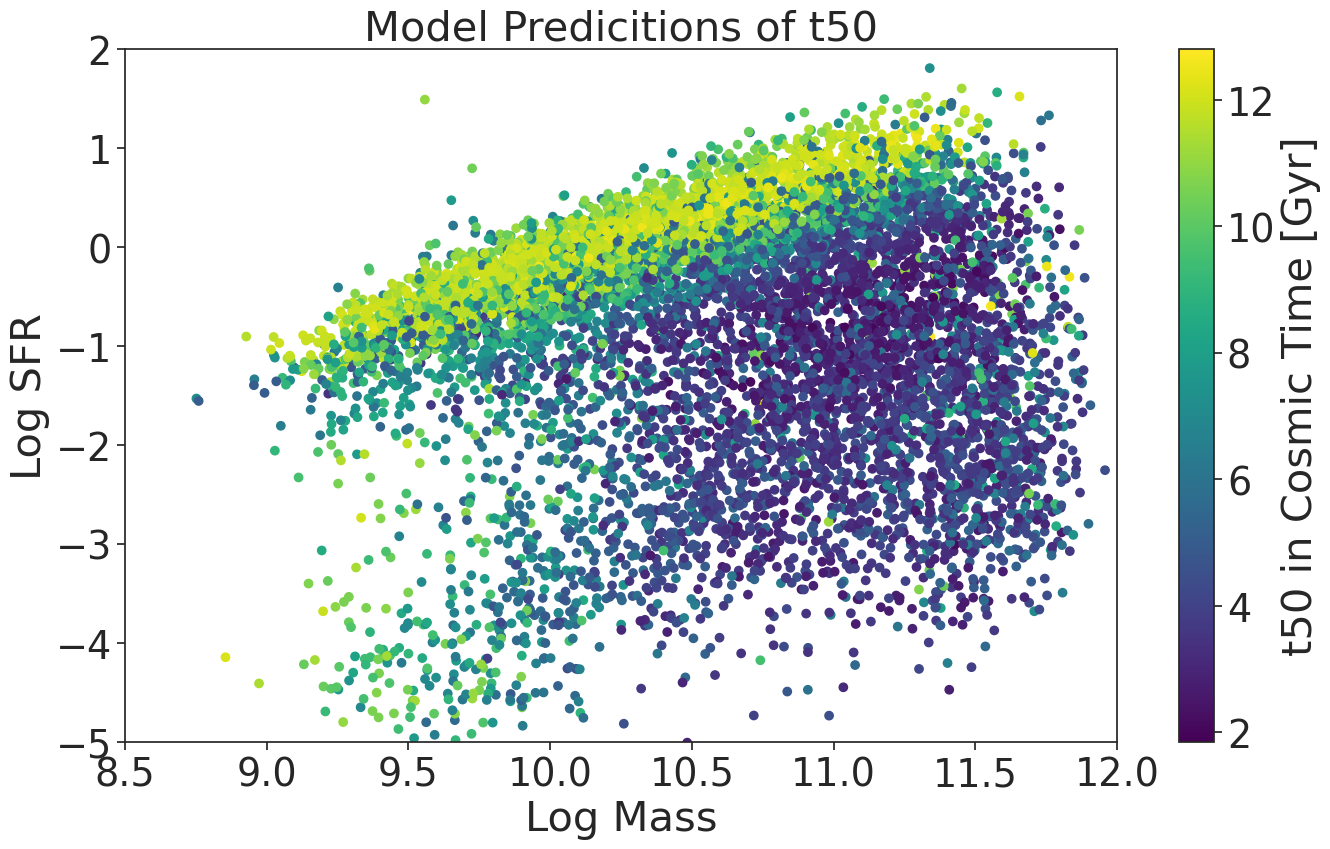

In [20]:
physical_index = np.where(10**np.array(train_t50_model_list) < 13.6)[0]

plt.figure(figsize=(16,9))
plt.scatter(np.array(train_mass_list)[physical_index],np.array(train_sfr_list)[physical_index],c=10**np.array(train_t50_model_list)[physical_index],cmap='viridis')
plt.title('Model Predicitions of t50')
plt.xlabel('Log Mass')
plt.ylabel('Log SFR')
plt.xlim(8.5,12)
plt.ylim(-5,2)
plt.colorbar(label='t50 in Cosmic Time [Gyr]')
plt.savefig('MaNGA_t50_new.pdf')

# Figure 5

In [ ]:
def plot_images_maps(xim = 5, yim = 5, imsize = 4, key='images', ids = [], sigma = 2,random_mode = False):
    
    if len(ids) == 0:
        if random_mode == True:
            ids = np.random.randint(len(d_im['images']),size=xim*yim)
        if random_mode == False:
            ids = np.arange(xim*yim)
    plt.subplots(figsize=(imsize*xim,imsize*yim))
    plt.subplots_adjust(hspace=0.01,wspace=0.01)
    
    shapmaps = []
    for i in range(xim*yim):
        plt.subplot(yim,xim,i+1)
        try:
            if key == 'images':

                plt.imshow(d_im['images'][ids[i]], origin='lower')
                tempx, tempy = plt.xlim(), plt.ylim()
                plt.text(tempx[1]*0.042, tempy[1]*0.9, 'Manga-id: '+manga_scalars['mangaid'][ids[i]], color='white', fontsize=14)
                plt.text(tempx[1]*0.042, tempy[1]*0.81, manga_scalars['split'][ids[i]], color='white', fontsize=12)
                plt.text(tempx[1]*0.04, tempy[1]*0.09, ' n: %.1f \n A$_V$: %.1f \n z: %.3f' %(manga_scalars['sersic_n'][ids[i]], manga_scalars['Av'][ids[i]], manga_scalars['redshift'][ids[i]]) , color='white', fontsize=14)
            elif key == 'shap_mass':            

                temp = d_shapmass['shap_map_mass'][ids[i]].copy()
                temp = ndimage.gaussian_filter(temp, sigma, mode='nearest')
                temp[np.abs(temp)<np.amax(np.nanpercentile(temp,[2,98]))] = np.nan
                # clim = np.amax(np.abs(np.nanpercentile(temp,[2,98])))
                clim = np.amax(np.abs(temp))
                plt.imshow(d_im['images'][ids[i]],alpha=0.4, origin='lower')
                plt.pcolor(np.sum(temp,2), cmap='bwr',alpha=0.9)
                tempx, tempy = plt.xlim(), plt.ylim()
                plt.text(tempx[1]*0.042, tempy[1]*0.9, 'log M$_*$: %.2f' %manga_scalars['log_mstar'][ids[i]], color='k', fontsize=14)
                plt.text(tempx[1]*0.042, tempy[1]*0.81, '$\Delta$M$_{*}^{\mathrm{pred}}$: %.1f' %(manga_scalars['log_mstar'][ids[i]] - manga_scalars['pred_mstar'][ids[i]]), color='k', fontsize=12)
                shapmaps.append(d_shapmass['shap_map_mass'][ids[i]].copy())
            elif key == 'shap_sfr':

                temp = d_shapsfr['shap_map_mass'][ids[i]].copy()
                temp = ndimage.gaussian_filter(temp, sigma, mode='nearest')
                temp[np.abs(temp)<np.amax(np.nanpercentile(temp,[2,98]))] = np.nan
                clim = np.amax(np.abs(np.nanpercentile(temp,[2,98])))
                plt.imshow(d_im['images'][ids[i]],alpha=0.4, origin='lower')
                plt.pcolor(np.sum(temp,2), cmap='bwr',alpha=0.9)
                tempx, tempy = plt.xlim(), plt.ylim()
                plt.text(tempx[1]*0.042, tempy[1]*0.9, 'log SFR: %.2f' %manga_scalars['log_sfr'][ids[i]], color='k', fontsize=14)
                plt.text(tempx[1]*0.042, tempy[1]*0.81, '$\Delta$SFR$^{\mathrm{pred}}$: %.1f' %(manga_scalars['log_sfr'][ids[i]] - manga_scalars['pred_sfr'][ids[i]]), color='k', fontsize=12)
                shapmaps.append(d_shapmass['shap_map_mass'][ids[i]].copy())
            elif key == 'shap_age':

                temp = d_shapage['shap_map_mass'][ids[i]].copy()
                temp = ndimage.gaussian_filter(temp, sigma, mode='nearest')
                temp[np.abs(temp)<np.amax(np.nanpercentile(temp,[2,98]))] = np.nan
                clim = np.amax(np.abs(np.nanpercentile(temp,[2,98])))
                plt.imshow(d_im['images'][ids[i]],alpha=0.4, origin='lower')
                plt.pcolor(np.sum(temp,2), cmap='bwr',alpha=0.9)
                tempx, tempy = plt.xlim(), plt.ylim()
                plt.text(tempx[1]*0.042, tempy[1]*0.9, 'd4000: %.2f' %manga_scalars['d4000'][ids[i]], color='k', fontsize=14)
                plt.text(tempx[1]*0.042, tempy[1]*0.81, '$\Delta$d4000$^{\mathrm{pred}}$: %.1f' %(manga_scalars['d4000'][ids[i]] - manga_scalars['pred_d4000'][ids[i]]), color='k', fontsize=12)
                shapmaps.append(d_shapmass['shap_map_mass'][ids[i]].copy())
            plt.axis('off')

        except:

            plt.axis('off')
            print('no shap for id = ',ids[i])
    return shapmaps

In [ ]:
ids = np.array([10066,  997, 4140, 8800, 9831, 3256, 4068, 3795, 2946, 2773])
sigmaval = 2.0
xim = 10
yim = 1


plot_images_maps(xim,yim, ids=ids, key='images', sigma=sigmaval)
# plt.savefig('gal_images_selected.png',dpi=500)
plot_images_maps(xim,yim, ids=ids, key='shap_mass', sigma=sigmaval)
# plt.savefig('gal_shap_mass_selected.png',dpi=500)
plot_images_maps(xim,yim, ids=ids, key='shap_sfr', sigma=sigmaval)
# plt.savefig('gal_shap_sfr_selected.png',dpi=500)
plot_images_maps(xim,yim, ids=ids, key='shap_age', sigma=sigmaval);
# plt.savefig('gal_shap_age_selected.png',dpi=500)

# Figure 6 

In [ ]:
def make_radial_shapplot_merger(mv, massbins, clabel, 
                         zbin = 0.1, zbw = 0.1, mbw = 0.5,):
    print(massbins)
    zv = manga_scalars['redshift']
    colors = cm.Spectral(np.linspace(0,1,len(massbins)))

    fig, ax = plt.subplots(1,3, figsize=(16,9))
    plt.subplot(1,3,1)
    plt.axhline(0,color='k',alpha=0.3)
    plt.fill_between([0,1],-40,20,color='grey',alpha=0.2) #bulge 
    plt.text(0.6, -17, 'Bulge', rotation=90, fontsize=18)
    plt.fill_between([5,15],-40,20,color='grey',alpha=0.2) #spirals
    plt.text(10, -17, 'Spirals', rotation=90, fontsize=18)
    plt.fill_between([20,150],-40,20,color='grey',alpha=0.2) #interactions
    plt.text(50, -17, 'Interactions', rotation=90, fontsize=18)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(ref_array, np.nanmedian(mass_avgs_interp[mask,0:],0),lw=3, color=colors[i])
        print(np.shape(mass_avgs_interp[mask,0:]))
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (M$_*$)',fontsize=14)
    # plt.xlim(1e-1,0.4e2)
    plt.ylim(-40,20)
    plt.xlim(0.1,150)

    plt.subplot(1,3,2)
    plt.axhline(0,color='k',alpha=0.3)
    plt.fill_between([0,1],-40,20,color='grey',alpha=0.2) #bulge 
    plt.text(0.6, -17, 'Bulge', rotation=90, fontsize=18)
    plt.fill_between([5,15],-40,20,color='grey',alpha=0.2) #spirals
    plt.text(10, -17, 'Spirals', rotation=90, fontsize=18)
    plt.fill_between([20,150],-40,20,color='grey',alpha=0.2) #interactions
    plt.text(50, -17, 'Interactions', rotation=90, fontsize=18)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(ref_array, np.nanmedian(sfr_avgs_interp[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (SFR)',fontsize=14)
    # plt.xlim(1e-1,0.4e2)
    plt.ylim(-40,20)
    plt.xlim(0.1,150)

    plt.subplot(1,3,3)
    plt.axhline(0,color='k',alpha=0.3)
    plt.fill_between([0,1],-4,2,color='grey',alpha=0.2) #bulge 
    plt.text(0.6, -0.75, 'Bulge', rotation=90, fontsize=18)
    plt.fill_between([5,15],-4,2,color='grey',alpha=0.2) #spirals
    plt.text(10, -0.75, 'Spirals', rotation=90, fontsize=18)
    plt.fill_between([20,150],-4,2,color='grey',alpha=0.2) #interactions
    plt.text(50, -0.75, 'Interactions', rotation=90, fontsize=18)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(ref_array, np.nanmedian(d4000_avgs_interp[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (d4000)',fontsize=14)
    plt.xlim(0.1,150)
    ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    plt.ylim(-1,1)

    # ----------------------------------------------------------
    im1 = plt.scatter(massbins*1000, np.zeros_like(massbins), c=massbins, cmap='Spectral')
    axins1 = inset_axes(
        ax[2],
        width="70%",  # width: 50% of parent_bbox width
        height="2%",  # height: 5%
        loc="upper right", borderpad=1.2
    )
    axins1.xaxis.set_ticks_position("both")
    clbr = fig.colorbar(im1, cax=axins1, orientation="horizontal")
    clbr.set_label(clabel)
    plt.tight_layout()
    # plt.savefig('merger_radial_shap.pdf')
    # plt.show()
    

In [ ]:
plt.rcParams.update({'font.size': 16})
# fig, ax = plt.subplots(3,3, figsize=(16,9))


make_radial_shapplot_merger(mv=manga_scalars['log_mstar'], 
                                      massbins=np.arange(9, 12.1, 0.3),
                                      clabel='log Stellar Mass')

plt.savefig('mass_radial_plot_new.png',dpi=500)

make_radial_shapplot_merger(mv=manga_scalars['log_sfr'] - manga_scalars['log_mstar'], 
                                massbins=np.arange(-15, -8, 0.3),
                                clabel='log sSFR',
                                zbin=0.1, zbw=0.1)

plt.savefig('sfr_radial_plot_new.png',dpi=500)

make_radial_shapplot_merger(mv=manga_scalars['d4000'], 
                                massbins=np.arange(0.9, 2.0, 0.1),
                                clabel='d4000')

plt.savefig('d4000_radial_plot_new.png',dpi=500)


import matplotlib.image as mpimg

# Define the file paths for your PNG images (replace these with your actual file paths)
image_path_a = 'mass_radial_plot_new.png'
image_path_b = 'sfr_radial_plot_new.png'
image_path_c = 'd4000_radial_plot_new.png'

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(4*4, 3*6))

# Load and display the PNG images in subplots
image_a = mpimg.imread(image_path_a)
axs[0].imshow(image_a)
# axs[0].set_title('Image a')
axs[0].axis('off')

image_b = mpimg.imread(image_path_b)
axs[1].imshow(image_b)
# axs[1].set_title('Image b')
axs[1].axis('off')

image_c = mpimg.imread(image_path_c)
axs[2].imshow(image_c)
# axs[2].set_title('Image c')
axs[2].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.savefig('primary_radial_plots_new.pdf')
plt.show()


# Figure 7

In [ ]:
mass_avgs = []
sfr_avgs = []
d4000_avgs = []
sigma = 2.0
for i in tqdm(range(len(d_shapmass['shap_map_mass']))):
    try:
        temp = np.mean(ndimage.gaussian_filter(d_shapmass['shap_map_mass'][i]*1e4, sigma, mode='nearest'),2)
        mass_avgs.append(azimuthalAverage(temp))
        temp = np.mean(ndimage.gaussian_filter(d_shapsfr['shap_map_mass'][i]*1e4, sigma, mode='nearest'),2)
        sfr_avgs.append(azimuthalAverage(temp))
        temp = np.mean(ndimage.gaussian_filter(d_shapage['shap_map_mass'][i]*1e4, sigma, mode='nearest'),2)
        d4000_avgs.append(azimuthalAverage(temp))
    except:
        mass_avgs.append(np.ones((179,))*np.nan)
        sfr_avgs.append(np.ones((179,))*np.nan)
        d4000_avgs.append(np.ones((179,))*np.nan)
mass_avgs = np.array(mass_avgs)
sfr_avgs = np.array(sfr_avgs)
d4000_avgs = np.array(d4000_avgs)

In [ ]:
common_x_axis = []
for i in range(len(mass_avgs)):
   common_x_axis.append(get_xax(manga_scalars['redshift'][i]))

def find_largest_array(arrays):
    largest_size = 0
    largest_array = []

    for array in arrays:
        if len(array) > largest_size:
            largest_size = len(array)
            largest_array = array

    return largest_array

ref_array = find_largest_array(common_x_axis)

mass_avgs_interp = []
for i in range(len(common_x_axis)):
    mass_avgs_interp.append(np.interp(ref_array, common_x_axis[i], mass_avgs[i]))

sfr_avgs_interp = []
for i in range(len(common_x_axis)):
    sfr_avgs_interp.append(np.interp(ref_array, common_x_axis[i], sfr_avgs[i]))

d4000_avgs_interp = []
for i in range(len(common_x_axis)):
    d4000_avgs_interp.append(np.interp(ref_array, common_x_axis[i], d4000_avgs[i]))

mass_avgs_interp = np.array(mass_avgs_interp)
sfr_avgs_interp = np.array(sfr_avgs_interp)
d4000_avgs_interp = np.array(d4000_avgs_interp)

In [ ]:
interest =  np.where((np.array(manga_scalars['log_mstar'])>11) & (np.array(manga_scalars['log_mstar'])<13) & (np.array(manga_scalars['d4000'])> 1.8) & (np.array(manga_scalars['d4000'])<2))[0]
print(len(interest))
plt.figure(figsize=(21,10))
for i in interest:
    if d4000_avgs_interp[i,0] > 0:
        plt.plot(ref_array, d4000_avgs_interp[i,:], color='blue', alpha=0.3)
    else:
        plt.plot(ref_array, d4000_avgs_interp[i,:], color='red', alpha=0.3)

plt.plot(ref_array, np.nanmedian(d4000_avgs_interp[interest,:],0), color='green', lw=3)
plt.hlines(0,0,2e2, color='black', alpha=1)
plt.xlim(0,20)

start_point = find_nearest_index(0, ref_array)
end_point = find_nearest_index(20, ref_array)

print(ref_array[start_point],ref_array[end_point])


mass_gradients = []
for i in range(len(mass_avgs_interp)):
    mass_gradients.append(mass_avgs_interp[i][end_point]-mass_avgs_interp[i][start_point])

sfr_gradients = []
for i in range(len(sfr_avgs_interp)):
    sfr_gradients.append(sfr_avgs_interp[i][end_point]-sfr_avgs_interp[i][start_point])

d4000_gradients = []
for i in range(len(d4000_avgs_interp)):
    d4000_gradients.append(d4000_avgs_interp[i][end_point]- d4000_avgs_interp[i][start_point])

make_radial_shapplot_interp(mv = manga_scalars['log_mstar'], 
                     massbins = np.arange(9,12.1,0.3),
                     clabel = 'log Stellar Mass')

make_radial_shapplot_interp(mv = manga_scalars['log_sfr'] - manga_scalars['log_mstar'], 
                     massbins = np.arange(-15,-8,0.3),
                     clabel = 'log sSFR',
                     zbin = 0.1, zbw = 0.1)

make_radial_shapplot_interp(mv = manga_scalars['d4000'], 
                     massbins = np.arange(0.9, 2.0, 0.1),
                     clabel = 'D4000')

In [ ]:
mask = np.where((np.array(manga_scalars['log_mstar'])<12) & (np.array(manga_scalars['d4000'])<3))[0]
# Create a figure and subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
# fig.suptitle('Galaxies on the $M_*$-SFR Plane Colored by Gradients', fontsize=18)
font_size=20
plt.rcParams.update({'font.size': font_size})

log_mstar = np.array(manga_scalars['log_mstar'])
log_sfr = np.array(manga_scalars['log_sfr'])
mass_gradients = np.array(mass_gradients)
sfr_gradients = np.array(sfr_gradients)
d4000_gradients = np.array(d4000_gradients)

subplot_titles = ['$M_*$ Gradient', 'SFR Gradient', 'D4000 Gradient']

# Plot the hexbin plots on each subplot
def plot_hexbin(ax, x, y, c, cmap, vmin, vmax, label):
    hb = ax.hexbin(x[mask], y[mask], C=c[mask], cmap=cmap, vmin=vmin, vmax=vmax, gridsize=20)
    ax.set_xlabel('log $M_*$ [M$_\odot$]',fontsize=font_size)
    ax.set_ylabel('log SFR [M$_\odot$ yr$^{-1}$]',fontsize=font_size)
    return hb

hb1 = plot_hexbin(axs[0], log_mstar, log_sfr, mass_gradients, 'Spectral_r', -30, 30, 'Mass Gradient')
hb2 = plot_hexbin(axs[1], log_mstar, log_sfr, sfr_gradients, 'Spectral_r', -40, 40, 'SFR Gradient')
hb3 = plot_hexbin(axs[2], log_mstar, log_sfr, d4000_gradients, 'Spectral_r', -2, 2, 'D4000 Gradient')


# Create a colorbar for each subplot
cbar1 = fig.colorbar(hb1, ax=axs[0], label='$M_*$ Gradient')
cbar2 = fig.colorbar(hb2, ax=axs[1], label='SFR Gradient')
cbar3 = fig.colorbar(hb3, ax=axs[2], label='D4000 Gradient')

# Set titles for each subplot
# for i, title in enumerate(subplot_titles):
#     axs[i].set_title(title)

plt.tight_layout()
# plt.savefig('hexbin_gradients.pdf')


# Figure 8

# Figure 9

# Figure 10 

# Figure 11

In [ ]:
mask = np.where((np.array(manga_scalars['log_mstar'])<12) & (np.array(manga_scalars['d4000'])<3))[0]
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 10))
# fig.suptitle('Galaxies on the $M_*$-SFR Plane Colored by Gradients', fontsize=18)
font_size=20
plt.rcParams.update({'font.size': font_size})

log_mstar = np.array(manga_scalars['log_mstar'])
log_sfr = np.array(manga_scalars['log_sfr'])
mass_gradients = np.array(mass_gradients)
sfr_gradients = np.array(sfr_gradients)
d4000_gradients = np.array(d4000_gradients)

subplot_titles = ['$M_*$ Gradient', 'SFR Gradient', 'D4000 Gradient']

# Plot the hexbin plots on each subplot
def plot_hexbin(ax, x, y, c, cmap, vmin, vmax, label):
    hb = ax.hexbin(x[mask], y[mask], C=c[mask], cmap=cmap, vmin=vmin, vmax=vmax, gridsize=20)
    ax.set_xlabel('log $M_*$ [M$_\odot$]',fontsize=font_size)
    ax.set_ylabel('log SFR [M$_\odot$ yr$^{-1}$]',fontsize=font_size)
    return hb

hb3 = plot_hexbin(axs[0], log_mstar, log_sfr, d4000_gradients, 'Spectral_r', -2, 2, 'D4000 Gradient')


# Create a colorbar for each subplot
cbar3 = fig.colorbar(hb3, ax=axs[0], label='D4000 Gradient')



plt.tight_layout()


# Figure 12

In [ ]:
import scipy.integrate as integrate

manga_scalars_clean_sfh = manga_scalars[manga_scalars['sfh'].notna()]
sfh = np.array(manga_scalars_clean_sfh['sfh'])
mass_avgs_interp_clean = mass_avgs_interp[manga_scalars['sfh'].notna()]
sfr_avgs_interp_clean = sfr_avgs_interp[manga_scalars['sfh'].notna()]
d4000_avgs_interp_clean = d4000_avgs_interp[manga_scalars['sfh'].notna()]

start_point = find_nearest_index(0, ref_array)
end_point = find_nearest_index(20, ref_array)

mass_center_shap = []
sfr_center_shap = []
d4000_center_shap = []

mass_gradients_sfh_clean = []
for i in range(len(mass_avgs_interp_clean)):
    mass_gradients_sfh_clean.append(mass_avgs_interp_clean[i][end_point]-mass_avgs_interp_clean[i][start_point])
    mass_center_shap.append(mass_avgs_interp_clean[i][start_point])

sfr_gradients_sfh_clean = []
for i in range(len(sfr_avgs_interp_clean)):
    sfr_gradients_sfh_clean.append(sfr_avgs_interp_clean[i][end_point]-sfr_avgs_interp_clean[i][start_point])
    sfr_center_shap.append(sfr_avgs_interp_clean[i][start_point])

d4000_gradients_sfh_clean = []
for i in range(len(d4000_avgs_interp_clean)):
    d4000_gradients_sfh_clean.append(d4000_avgs_interp_clean[i][end_point]- d4000_avgs_interp_clean[i][start_point])
    d4000_center_shap.append(d4000_avgs_interp_clean[i][start_point])

sfh_time = sfh[0][0,:] 

current_time = np.max(sfh_time)

dx = (sfh_time[-1]-sfh_time[0])/len(sfh_time)

#100 million years ago
index_01 = find_nearest_index(current_time-0.1, sfh_time)
sfr_01 = []
mass_01 = [] #Mass at the given time (calculated by taking current stellar mass and substracting the integral of the SFH from the current time to the given time)
for i in range(len(sfh)):
    sfr_01.append(sfh[i][1][index_01])
    mass_01.append(10**np.array(manga_scalars_clean_sfh['log_mstar'])[i]- np.trapz(sfh[i][1][index_01:], sfh[i][0][index_01:], dx=dx)) 

#300 million years ago
index_03 = find_nearest_index(current_time-0.3, sfh_time)
sfr_03 = []
mass_03 = []
for i in range(len(sfh)):
    sfr_03.append(sfh[i][1][index_03])
    mass_03.append(10**np.array(manga_scalars_clean_sfh['log_mstar'])[i]- np.trapz(sfh[i][1][index_03:], sfh[i][0][index_03:], dx=dx))

#500 million years ago
index_05 = find_nearest_index(current_time-0.5, sfh_time)
sfr_05 = []
mass_05 =[]
for i in range(len(sfh)):
    sfr_05.append(sfh[i][1][index_05])
    mass_05.append(10**np.array(manga_scalars_clean_sfh['log_mstar'])[i]- np.trapz(sfh[i][1][index_05:], sfh[i][0][index_05:], dx=dx))

#1 billion years ago
index_1 = find_nearest_index(current_time-1, sfh_time)
sfr_1 = []
mass_1 =[]
for i in range(len(sfh)):
    sfr_1.append(sfh[i][1][index_1])
    mass_1.append(10**np.array(manga_scalars_clean_sfh['log_mstar'])[i]- np.trapz(sfh[i][1][index_1:], sfh[i][0][index_1:], dx=dx))

#3 billion years ago
index_3 = find_nearest_index(current_time-3, sfh_time)
sfr_3 = []
mass_3 = []
for i in range(len(sfh)):
    sfr_3.append(sfh[i][1][index_3])
    mass_3.append(10**np.array(manga_scalars_clean_sfh['log_mstar'])[i]- np.trapz(sfh[i][1][index_3:], sfh[i][0][index_3:], dx=dx))

#5 billion years ago
index_5 = find_nearest_index(current_time-5, sfh_time)
sfr_5 = []
mass_5= []
for i in range(len(sfh)):
    sfr_5.append(sfh[i][1][index_5])
    mass_5.append(10**np.array(manga_scalars_clean_sfh['log_mstar'])[i]- np.trapz(sfh[i][1][index_5:], sfh[i][0][index_5:], dx=dx))

#10 billion years ago
index_10 = find_nearest_index(current_time-10, sfh_time)
sfr_10 = []
mass_10=[]
for i in range(len(sfh)):
    sfr_10.append(sfh[i][1][index_10])
    mass_10.append(10**np.array(manga_scalars_clean_sfh['log_mstar'])[i]- np.trapz(sfh[i][1][index_10:], sfh[i][0][index_10:], dx=dx))

#12 billion years ago
index_12 = find_nearest_index(current_time-12, sfh_time)
sfr_12 = []
mass_12 = []
for i in range(len(sfh)):
    sfr_12.append(sfh[i][1][index_12])
    mass_12.append(10**np.array(manga_scalars_clean_sfh['log_mstar'])[i]- np.trapz(sfh[i][1][index_12:], sfh[i][0][index_12:], dx=dx))

sfr_01 = np.array(sfr_01) 
sfr_03 = np.array(sfr_03)
sfr_05 = np.array(sfr_05)
sfr_1 = np.array(sfr_1)
sfr_3 = np.array(sfr_3)
sfr_5 = np.array(sfr_5)
sfr_10 = np.array(sfr_10)
sfr_12 = np.array(sfr_12)

sfr_01 = np.log10(sfr_01+1e-10) #taking log of SFR and adding dampening factor for values equal to 0
sfr_03 = np.log10(sfr_03+1e-10)
sfr_05 = np.log10(sfr_05+1e-10)
sfr_1 = np.log10(sfr_1+1e-10)
sfr_3 = np.log10(sfr_3+1e-10)
sfr_5 = np.log10(sfr_5+1e-10)
sfr_10 = np.log10(sfr_10+1e-10)
sfr_12 = np.log10(sfr_12+1e-10)

mass_01 = np.array(mass_01) 
mass_03 = np.array(mass_03)
mass_05 = np.array(mass_05)
mass_1 = np.array(mass_1)
mass_3 = np.array(mass_3)
mass_5 = np.array(mass_5)
mass_10 = np.array(mass_10)
mass_12 = np.array(mass_12)

mass_01 = np.log10(mass_01)
mass_03 = np.log10(mass_03)
mass_05 = np.log10(mass_05)
mass_1 = np.log10(mass_1)
mass_3 = np.log10(mass_3)
mass_5 = np.log10(mass_5)
mass_10 = np.log10(mass_10)
mass_12 = np.log10(mass_12)


In [ ]:
sfr_interest= [sfr_01, sfr_03, sfr_05, sfr_1, sfr_3, sfr_5, sfr_10, sfr_12]
mass_interest = [mass_01, mass_03, mass_05, mass_1, mass_3, mass_5, mass_10, mass_12]
label_interest = ['100 Myr ago', '300 Myr ago', '500 Myr ago', '1 Gyr ago', '3 Gyr ago', '5 Gyr ago', '10 Gyr ago', '12 Gyr ago']


for i in range(len(sfr_interest)):
    mask = np.where((np.array(manga_scalars_clean_sfh['log_mstar'])<13) & (np.array(manga_scalars_clean_sfh['d4000'])<3) & (sfr_interest[i]>-4) & (sfr_interest[i]<4))[0]
    plt.figure(figsize=(12,9))
    plt.hexbin(mass_interest[i][mask], sfr_interest[i][mask],C=np.array(d4000_gradients_sfh_clean)[mask],cmap= 'Spectral_r', vmin = -2, vmax=2,gridsize=20)
    plt.xlabel('log mass')
    plt.ylabel('log SFR')
    plt.title(label_interest[i])
    plt.colorbar(label='D4000 Gradient')
    # plt.savefig('/home/juanpabloalfonzo/Documents/Manga CNNs/SFH Gradient/d4000_gradient_'+label_interest[i]+'.png')

In [ ]:
sfr_interest= [sfr_01, sfr_03, sfr_05, sfr_5, sfr_12]
mass_interest = [mass_01, mass_03, mass_05, mass_5, mass_12]
label_interest = ['0.1 Gyr Ago','0.3 Gyr Ago', '0.5 Gyr Ago', '5 Gyr Ago', '12 Gyr Ago']

j=0
k=0
plt.rcParams['font.size'] = 40
plt.subplots(3,5, figsize=(100,50))
for i in range(len(sfr_interest)*3):
    if i <5:
        mask = np.where((np.array(manga_scalars_clean_sfh['log_mstar'])<13) & (np.array(manga_scalars_clean_sfh['d4000'])<3) & (sfr_interest[i]>-4) & (sfr_interest[i]<4))[0]
        plt.subplot(3,5,i+1)
        plt.hexbin(mass_interest[i][mask], sfr_interest[i][mask],C=np.array(mass_gradients_sfh_clean)[mask],cmap= 'Spectral_r', vmin = -30, vmax=30,gridsize=20)
        plt.xlabel('log $M_*$ [M$_\odot$]')
        plt.ylabel('log SFR [M$_\odot$ yr$^{-1}$]')
        plt.title(label_interest[i])
        plt.colorbar(label='$M_*$ Gradient')

    elif i<10:
        mask = np.where((np.array(manga_scalars_clean_sfh['log_mstar'])<13) & (np.array(manga_scalars_clean_sfh['d4000'])<3) & (sfr_interest[j]>-4) & (sfr_interest[j]<4))[0]
        plt.subplot(3,5,i+1)
        plt.hexbin(mass_interest[j][mask], sfr_interest[j][mask],C=np.array(sfr_gradients_sfh_clean)[mask],cmap= 'Spectral_r', vmin = -40, vmax=40,gridsize=20)
        plt.xlabel('log $M_*$ [M$_\odot$]')
        plt.ylabel('log SFR [M$_\odot$ yr$^{-1}$]')
        # plt.title(label_interest[j])
        plt.colorbar(label='SFR Gradient')
        j=j+1
    
    elif i < 15:
        mask = np.where((np.array(manga_scalars_clean_sfh['log_mstar'])<13) & (np.array(manga_scalars_clean_sfh['d4000'])<3) & (sfr_interest[k]>-4) & (sfr_interest[k]<4))[0]
        plt.subplot(3,5,i+1)
        plt.hexbin(mass_interest[k][mask], sfr_interest[k][mask],C=np.array(d4000_gradients_sfh_clean)[mask],cmap= 'Spectral_r', vmin = -2, vmax=2,gridsize=20)
        plt.xlabel('log $M_*$ [M$_\odot$]')
        plt.ylabel('log SFR [M$_\odot$ yr$^{-1}$]')
        # plt.title(label_interest[k])
        plt.colorbar(label='D4000 Gradient')
        k=k+1
    

    plt.tight_layout()
    # plt.savefig('morph-sfh-extended.pdf')


In [ ]:
sfr_interest= [sfr_01, sfr_1, sfr_10]
mass_interest = [mass_01, mass_1, mass_10]
label_interest = ['0.1 Gyr Ago','1 Gyr Ago', '10 Gyr Ago']

j=0
k=0
plt.rcParams['font.size'] = 40
plt.subplots(3,3, figsize=(42,36))
for i in range(len(sfr_interest)*3):
    if i <3:
        mask = np.where((np.array(manga_scalars_clean_sfh['log_mstar'])<13) & (np.array(manga_scalars_clean_sfh['d4000'])<3) & (sfr_interest[i]>-4) & (sfr_interest[i]<4))[0]
        plt.subplot(3,3,i+1)
        plt.hexbin(mass_interest[i][mask], sfr_interest[i][mask],C=np.array(mass_gradients_sfh_clean)[mask],cmap= 'Spectral_r', vmin = -30, vmax=30,gridsize=20)
        plt.xlabel('log $M_*$ [M$_\odot$]')
        plt.ylabel('log SFR [M$_\odot$ yr$^{-1}$]')
        plt.title(label_interest[i])
        plt.colorbar(label='$M_*$ Gradient')

    elif i<6:
        mask = np.where((np.array(manga_scalars_clean_sfh['log_mstar'])<13) & (np.array(manga_scalars_clean_sfh['d4000'])<3) & (sfr_interest[j]>-4) & (sfr_interest[j]<4))[0]
        plt.subplot(3,3,i+1)
        plt.hexbin(mass_interest[j][mask], sfr_interest[j][mask],C=np.array(sfr_gradients_sfh_clean)[mask],cmap= 'Spectral_r', vmin = -40, vmax=40,gridsize=20)
        plt.xlabel('log $M_*$ [M$_\odot$]')
        plt.ylabel('log SFR [M$_\odot$ yr$^{-1}$]')
        # plt.title(label_interest[j])
        plt.colorbar(label='SFR Gradient')
        j=j+1
    
    elif i < 9:
        mask = np.where((np.array(manga_scalars_clean_sfh['log_mstar'])<13) & (np.array(manga_scalars_clean_sfh['d4000'])<3) & (sfr_interest[k]>-4) & (sfr_interest[k]<4))[0]
        plt.subplot(3,3,i+1)
        plt.hexbin(mass_interest[k][mask], sfr_interest[k][mask],C=np.array(d4000_gradients_sfh_clean)[mask],cmap= 'Spectral_r', vmin = -2, vmax=2,gridsize=20)
        plt.xlabel('log $M_*$ [M$_\odot$]')
        plt.ylabel('log SFR [M$_\odot$ yr$^{-1}$]')
        # plt.title(label_interest[k])
        plt.colorbar(label='D4000 Gradient')
        k=k+1
    

    plt.tight_layout()
    # plt.savefig('morph-sfh_2.pdf')


# Figure 13

In [ ]:
mask = np.where((np.array(manga_scalars['log_mstar'])<12) & (np.array(manga_scalars['d4000'])<3))[0]
# Create a figure and subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 16))
# fig.suptitle('Galaxies on the $M_*$-SFR Plane Colored by Gradients', fontsize=18)
font_size=20
plt.rcParams.update({'font.size': font_size})

log_mstar = np.array(manga_scalars['log_mstar'])
log_sfr = np.array(manga_scalars['log_sfr'])
d4000 = np.array(manga_scalars['d4000'])
mass_gradients = np.array(mass_gradients)
sfr_gradients = np.array(sfr_gradients)
d4000_gradients = np.array(d4000_gradients)

subplot_titles = ['$M_*$ Gradient', 'SFR Gradient', 'D4000 Gradient']

# Plot the hexbin plots on each subplot
def plot_hexbin(ax, x, y, c, cmap, vmin, vmax, label):
    hb = ax.hexbin(x[mask], y[mask], C=c[mask], cmap=cmap, vmin=vmin, vmax=vmax, gridsize=20)
    ax.set_xlabel('log $M_*$ [M$_\odot$]',fontsize=font_size)
    ax.set_ylabel('D4000',fontsize=font_size)
    return hb

hb1 = plot_hexbin(axs[0], log_mstar, d4000, mass_gradients, 'Spectral_r', -30, 30, 'Mass Gradient')
hb2 = plot_hexbin(axs[1], log_mstar, d4000, sfr_gradients, 'Spectral_r', -40, 40, 'SFR Gradient')
hb3 = plot_hexbin(axs[2], log_mstar, d4000, d4000_gradients, 'Spectral_r', -2, 2, 'D4000 Gradient')


# Create a colorbar for each subplot
cbar1 = fig.colorbar(hb1, ax=axs[0], label='$M_*$ Gradient')
cbar2 = fig.colorbar(hb2, ax=axs[1], label='SFR Gradient')
cbar3 = fig.colorbar(hb3, ax=axs[2], label='D4000 Gradient')

# Set titles for each subplot
# for i, title in enumerate(subplot_titles):
#     axs[i].set_title(title)

plt.tight_layout()
# plt.savefig('hexbin_gradients_d4000_ext.pdf')


# Figure 14 

In [ ]:
mask = np.where((np.array(manga_scalars['log_mstar'])<12) & (np.array(manga_scalars['d4000'])<3) & (np.array(manga_scalars['spirals'])>0))[0]
# Create a figure and subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 16))
# fig.suptitle('Galaxies on the $M_*$-SFR Plane Colored by Gradients', fontsize=18)
font_size=20
plt.rcParams.update({'font.size': font_size})

log_mstar = np.array(manga_scalars['log_mstar'])
log_sfr = np.array(manga_scalars['log_sfr'])
d4000 = np.array(manga_scalars['d4000'])
sersic = np.array(manga_scalars['sersic_n'])
p_spirals = np.array(manga_scalars['spirals'])
mass_gradients = np.array(mass_gradients)
sfr_gradients = np.array(sfr_gradients)
d4000_gradients = np.array(d4000_gradients)

subplot_titles = ['$M_*$ Gradient', 'SFR Gradient', 'D4000 Gradient']

# Plot the hexbin plots on each subplot
def plot_hexbin(ax, x, y, c, cmap, vmin, vmax, label):
    hb = ax.hexbin(x[mask], y[mask], C=c[mask], cmap=cmap, vmin=vmin, vmax=vmax, gridsize=20)
    ax.set_xlabel('sSFR [yr$^{-1}$]',fontsize=font_size)
    ax.set_ylabel('P(spiral)',fontsize=font_size)
    return hb

hb1 = plot_hexbin(axs[0], log_sfr-log_mstar, p_spirals, mass_gradients, 'Spectral_r', -50, 50, 'Mass Gradient')
hb2 = plot_hexbin(axs[1], log_sfr-log_mstar, p_spirals, sfr_gradients, 'Spectral_r', -60, 60, 'SFR Gradient')
hb3 = plot_hexbin(axs[2], log_sfr-log_mstar, p_spirals, d4000_gradients,'Spectral_r', -2, 2, 'D4000 Gradient')


# Create a colorbar for each subplot
cbar1 = fig.colorbar(hb1, ax=axs[0], label='$M_*$ Gradient')
cbar2 = fig.colorbar(hb2, ax=axs[1], label='SFR Gradient')
cbar3 = fig.colorbar(hb3, ax=axs[2], label='D4000 Gradient')

# Set titles for each subplot
# for i, title in enumerate(subplot_titles):
#     axs[i].set_title(title)

plt.tight_layout()
# plt.savefig('morph-sfr-mass_ext.pdf')


# Figure 15

# Figure 16

In [ ]:
def make_radial_shapplot_quiescent(mv, massbins, clabel, 
                         zbin = 0.1, zbw = 0.1, mbw = 0.5,):
    print(massbins)
    zv = manga_scalars['redshift']
    colors = cm.Spectral(np.linspace(0,1,len(massbins)))

    fig, ax = plt.subplots(1,3, figsize=(16,9))
    plt.subplot(1,3,1)
    plt.axhline(0,color='k',alpha=0.3)
    plt.fill_between([0,1],-40,20,color='grey',alpha=0.2) #bulge 
    plt.text(0.6, -17, 'Bulge', rotation=90, fontsize=18)
    plt.fill_between([5,15],-40,20,color='grey',alpha=0.2) #spirals
    plt.text(10, -17, 'Spirals', rotation=90, fontsize=18)
    plt.fill_between([20,200],-40,20,color='grey',alpha=0.2) #interactions
    plt.text(50, -17, 'Interactions', rotation=90, fontsize=18)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw) & (np.array(manga_scalars['log_sfr']-manga_scalars['log_mstar']) > -10.8)
        plt.plot(ref_array, np.nanmedian(mass_avgs_interp[mask,0:],0),lw=3, color=colors[i])
        print(np.shape(mass_avgs_interp[mask,0:]))
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (M$_*$)',fontsize=14)
    # plt.xlim(1e-1,0.4e2)
    plt.xlim(0.3,150)
    plt.ylim(-40,20)

    plt.subplot(1,3,2)
    plt.axhline(0,color='k',alpha=0.3)
    plt.fill_between([0,1],-40,20,color='grey',alpha=0.2) #bulge 
    plt.text(0.6, -17, 'Bulge', rotation=90, fontsize=18)
    plt.fill_between([5,15],-40,20,color='grey',alpha=0.2) #spirals
    plt.text(10, -17, 'Spirals', rotation=90, fontsize=18)
    plt.fill_between([20,200],-40,20,color='grey',alpha=0.2) #interactions
    plt.text(50, -17, 'Interactions', rotation=90, fontsize=18)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw) & (np.array(manga_scalars['log_sfr']-manga_scalars['log_mstar']) > -10.8)
        plt.plot(ref_array, np.nanmedian(sfr_avgs_interp[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (SFR)',fontsize=14)
    # plt.xlim(1e-1,0.4e2)
    plt.xlim(0.3,150)
    plt.ylim(-40,20)

    plt.subplot(1,3,3)
    plt.axhline(0,color='k',alpha=0.3)
    plt.fill_between([0,1],-2,2,color='grey',alpha=0.2) #bulge 
    plt.text(0.6, -1.5, 'Bulge', rotation=90, fontsize=18)
    plt.fill_between([5,15],-2,2,color='grey',alpha=0.2) #spirals
    plt.text(10, -1.5, 'Spirals', rotation=90, fontsize=18)
    plt.fill_between([20,200],-2,2,color='grey',alpha=0.2) #interactions
    plt.text(50, -1.5, 'Interactions', rotation=90, fontsize=18)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw) & (np.array(manga_scalars['log_sfr']-manga_scalars['log_mstar']) > -10.8)
        plt.plot(ref_array, np.nanmedian(d4000_avgs_interp[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (d4000)',fontsize=14)
    plt.xlim(0.3,150)
    plt.ylim(-2,2)
    ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2g'))

    # ----------------------------------------------------------
    im1 = plt.scatter(massbins*1000, np.zeros_like(massbins), c=massbins, cmap='Spectral')
    axins1 = inset_axes(
        ax[2],
        width="70%",  # width: 50% of parent_bbox width
        height="2%",  # height: 5%
        loc="upper right", borderpad=1.2
    )
    axins1.xaxis.set_ticks_position("both")
    clbr = fig.colorbar(im1, cax=axins1, orientation="horizontal")
    clbr.set_label(clabel)
    plt.tight_layout()
    plt.savefig('quiescent_radial_shap.pdf',dpi=300)
    plt.show()
    
make_radial_shapplot_quiescent(mv = np.array(manga_scalars['t50_model']), 
                     massbins = np.arange(0,12,0.3),
                     clabel = 't50')


In [ ]:
plt.subplots(1,10,figsize=(16,9))
for i in range(len(t50args[1:])):
    plt.subplot(1,10,i+1)
    plt.imshow(d_im['images'][t50args[1:][i]])
    plt.text(5,25,'t50: '+ str(np.array(manga_scalars['t50_model'])[t50args[1:][i]])[:4]+' Gyrs',color='white',fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.savefig('quiescent_t50.pdf')    

# Figure 17

In [ ]:
def make_radial_shapplot_merger(mv, massbins, clabel, 
                         zbin = 0.1, zbw = 0.1, mbw = 0.5,):
    print(massbins)
    zv = manga_scalars['redshift']
    colors = cm.Spectral(np.linspace(0,1,len(massbins)))

    fig, ax = plt.subplots(1,3, figsize=(16,9))
    plt.subplot(1,3,1)
    plt.axhline(0,color='k',alpha=0.3)
    plt.fill_between([0,1],-40,20,color='grey',alpha=0.2) #bulge 
    plt.text(0.6, -17, 'Bulge', rotation=90, fontsize=18)
    plt.fill_between([5,15],-40,20,color='grey',alpha=0.2) #spirals
    plt.text(10, -17, 'Spirals', rotation=90, fontsize=18)
    plt.fill_between([20,150],-40,20,color='grey',alpha=0.2) #interactions
    plt.text(50, -17, 'Interactions', rotation=90, fontsize=18)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(ref_array, np.nanmedian(mass_avgs_interp[mask,0:],0),lw=3, color=colors[i])
        print(np.shape(mass_avgs_interp[mask,0:]))
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (M$_*$)',fontsize=14)
    # plt.xlim(1e-1,0.4e2)
    plt.ylim(-40,20)
    plt.xlim(0.1,150)

    plt.subplot(1,3,2)
    plt.axhline(0,color='k',alpha=0.3)
    plt.fill_between([0,1],-40,20,color='grey',alpha=0.2) #bulge 
    plt.text(0.6, -17, 'Bulge', rotation=90, fontsize=18)
    plt.fill_between([5,15],-40,20,color='grey',alpha=0.2) #spirals
    plt.text(10, -17, 'Spirals', rotation=90, fontsize=18)
    plt.fill_between([20,150],-40,20,color='grey',alpha=0.2) #interactions
    plt.text(50, -17, 'Interactions', rotation=90, fontsize=18)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(ref_array, np.nanmedian(sfr_avgs_interp[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (SFR)',fontsize=14)
    # plt.xlim(1e-1,0.4e2)
    plt.ylim(-40,20)
    plt.xlim(0.1,150)

    plt.subplot(1,3,3)
    plt.axhline(0,color='k',alpha=0.3)
    plt.fill_between([0,1],-4,2,color='grey',alpha=0.2) #bulge 
    plt.text(0.6, -0.75, 'Bulge', rotation=90, fontsize=18)
    plt.fill_between([5,15],-4,2,color='grey',alpha=0.2) #spirals
    plt.text(10, -0.75, 'Spirals', rotation=90, fontsize=18)
    plt.fill_between([20,150],-4,2,color='grey',alpha=0.2) #interactions
    plt.text(50, -0.75, 'Interactions', rotation=90, fontsize=18)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(ref_array, np.nanmedian(d4000_avgs_interp[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (d4000)',fontsize=14)
    plt.xlim(0.1,150)
    ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
    plt.ylim(-1,1)

    # ----------------------------------------------------------
    im1 = plt.scatter(massbins*1000, np.zeros_like(massbins), c=massbins, cmap='Spectral')
    axins1 = inset_axes(
        ax[2],
        width="70%",  # width: 50% of parent_bbox width
        height="2%",  # height: 5%
        loc="upper right", borderpad=1.2
    )
    axins1.xaxis.set_ticks_position("both")
    clbr = fig.colorbar(im1, cax=axins1, orientation="horizontal")
    clbr.set_label(clabel)
    plt.tight_layout()
    # plt.savefig('merger_radial_shap.pdf')
    # plt.show()

merger_clean = np.array(manga_scalars['p_merger'])
merger_clean = np.nan_to_num(merger_clean, nan=-1)
mask3 = np.where((merger_clean > 0.5))[0]

mask = merger_clean > 0
merger_mask = (manga_scalars['log_sfr'] - manga_scalars['log_mstar'])[mask]
idvals = np.arange(len(mask))[mask]

merger_vals = np.linspace(-17,-9.5,11)
mergerargs = []
for i in range(len(merger_vals)):
    tmp = idvals[np.argmin(np.abs(merger_mask - merger_vals[i]))]
    mergerargs.append(tmp)

plt.rcParams['font.size'] = 18
make_radial_shapplot_merger(mv = merger_clean, 
                     massbins = np.arange(0,1.1,0.1),
                     clabel = 'p(merger)',mbw = 0.01)
    

In [ ]:
plt.subplots(1,10,figsize=(16,9))
for i in range(len(mergerargs[1:])):
    plt.subplot(1,10,i+1)
    plt.imshow(d_im['images'][mergerargs[1:][i]])
    # plt.text(5,20,'sSFR: '+ str(np.array(manga_scalars['log_sfr'] - manga_scalars['log_mstar'])[mergerargs[1:][i]])[:6],color='white',fontsize=8)
    plt.text(5,20,'p(merger): '+ str(np.array(manga_scalars['p_merger'])[mergerargs[1:][i]])[:6],color='white',fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.savefig('merger_prob.pdf')

# Figure 18

# Figure 19 

In [ ]:
model = models.resnet50()
model.fc= nn.Linear(2048, 1)
model = nn.DataParallel(model,device_ids=(0,1))
model_used = 'Manga_(DR17)_ResNet50_SFR'
# model_used = 'd4000'
model.load_state_dict(torch.load(work_dir+'models/'+model_used+'.pytorch'),strict=True)
model.to('cuda')
model.eval()

#Run images through the model and extract the predicitions

predictions_train =[]
predictions_test =[]

incomplete_batch_id_test=len(val_ids)-1

remainder_test=len(val_ids[incomplete_batch_id_test])

total_values_test=(len(val_ids)*batch_size)-(batch_size-remainder_test)

incomplete_batch_id_train=len(train_ids)-1

remainder_train=len(train_ids[incomplete_batch_id_train])

total_values_train=(len(train_ids)*batch_size)-(batch_size-remainder_train)


for batch_idx, temp in enumerate(train_loader):
    image = temp['image'].to('cuda')
    outputs = model(image).detach().cpu().numpy()
    if batch_idx<incomplete_batch_id_train:
        for j in range(batch_size):     
            predictions_train.append(outputs[j])
    else:
        for k in range(remainder_train):
            predictions_train.append(outputs[k])

for batch_idx, temp in enumerate(val_loader):
    image = temp['image'].to('cuda')
    outputs = model(image).detach().cpu().numpy()
    if batch_idx<incomplete_batch_id_test:
        for j in range(batch_size):     
            predictions_test.append(outputs[j])
    else:
        for k in range(remainder_test):
            predictions_test.append(outputs[k])

In [ ]:

predictions_train_sfr = predictions_train
predictions_test_sfr = predictions_test

outlier_index_train = np.where((np.array(predictions_train_sfr)>-6) & (np.array(predictions_train_sfr)<3))[0]
outlier_index_test = np.where(np.array(predictions_test_sfr)>-6)[0]

# outlier_index_train = np.arange(0,len(predictions_train_sfr))
# outlier_index_test = np.arange(0,len(predictions_test_sfr))

plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Train Data Set')
plt.scatter(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train],alpha=0.3)
plt.plot([-4,2],[-4,2],'k--')
plt.text(1,-4,'$R^2$ Train ='+str((r2_score(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1,-4.5,'MSE Train ='+str((mean_squared_error(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1,-5,'MAD Train ='+str((mean_absolute_error(np.array(train_sfr_list)[outlier_index_train],np.array(predictions_train_sfr)[outlier_index_train])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.subplot(1,2,2)
plt.title('Test Data Set')
plt.scatter(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test],alpha=0.3,c='red')
plt.plot([-4,2],[-4,2],'k--')
plt.text(0,-3,'$R^2$ Test ='+str((r2_score(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.text(0,-3.5,'MSE Test ='+str((mean_squared_error(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.text(0,-4,'MAD Test ='+str((mean_absolute_error(np.array(test_sfr_list)[outlier_index_test],np.array(predictions_test_sfr)[outlier_index_test])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

In [ ]:
model = models.resnet50()
model.fc= nn.Linear(2048, 1)
model = nn.DataParallel(model,device_ids=(0,1))
model_used = 'Manga_(DR17)_ResNet50_t50'
# model_used = 'd4000'
model.load_state_dict(torch.load(work_dir+'models/'+model_used+'.pytorch'),strict=True)
model.to('cuda')
model.eval()

#Run images through the model and extract the predicitions

predictions_train =[]
predictions_test =[]

incomplete_batch_id_test=len(val_ids)-1

remainder_test=len(val_ids[incomplete_batch_id_test])

total_values_test=(len(val_ids)*batch_size)-(batch_size-remainder_test)

incomplete_batch_id_train=len(train_ids)-1

remainder_train=len(train_ids[incomplete_batch_id_train])

total_values_train=(len(train_ids)*batch_size)-(batch_size-remainder_train)


for batch_idx, temp in enumerate(train_loader):
    image = temp['image'].to('cuda')
    outputs = model(image).detach().cpu().numpy()
    if batch_idx<incomplete_batch_id_train:
        for j in range(batch_size):     
            predictions_train.append(outputs[j])
    else:
        for k in range(remainder_train):
            predictions_train.append(outputs[k])

for batch_idx, temp in enumerate(val_loader):
    image = temp['image'].to('cuda')
    outputs = model(image).detach().cpu().numpy()
    if batch_idx<incomplete_batch_id_test:
        for j in range(batch_size):     
            predictions_test.append(outputs[j])
    else:
        for k in range(remainder_test):
            predictions_test.append(outputs[k])

In [ ]:
#Please note that due to old naming conventions the "t50 predictions" are actually the d4000 predictions

predictions_train_t50 = predictions_train
predictions_test_t50 = predictions_test


outlier_index_train = np.where(np.array(train_t50_list)<4)[0]

plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Train Data Set')
plt.scatter(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train],alpha=0.3)
plt.plot([0.6,2],[0.6,2],'k--')
# plt.ylim(top=2)
plt.text(1.6,0.8,'$R^2$ Train ='+str((r2_score(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1.59,0.7,'MSE Train ='+str((mean_squared_error(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.text(1.59,0.6,'MAD Train ='+str((mean_absolute_error(np.array(train_t50_list)[outlier_index_train],np.array(predictions_train_t50)[outlier_index_train])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.subplot(1,2,2)
plt.title('Test Data Set')
plt.scatter(np.array(test_t50_list),predictions_test_t50,alpha=0.3,c='red')
plt.plot([1,2],[1,2],'k--')
plt.text(1.7,1.15,'$R^2$ Test ='+str((r2_score(np.array(test_t50_list),predictions_test_t50)))[0:5],fontsize='small')
plt.text(1.7,1.1,'MSE test ='+str((mean_squared_error(np.array(test_t50_list)[outlier_index_test],np.array(predictions_test_t50)[outlier_index_test])))[0:5],fontsize='small')
plt.text(1.7,1.05,'MAD test ='+str((mean_absolute_error(np.array(test_t50_list)[outlier_index_test],np.array(predictions_test_t50)[outlier_index_test])))[0:5],fontsize='small')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Figure 20

In [ ]:
mask = np.where((np.array(manga_scalars['log_mstar'])>8) & (np.array(manga_scalars['log_mstar'])<13) & (np.array(manga_scalars['t50_model'])<13))[0]
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(21,9))
plt.subplot(1,2,1)
plt.title('Model Predicitions of t50')
# plt.figure(figsize=(12,9))
plt.xlabel('log $M_*$ [$M_\odot$]')
plt.ylabel('log SFR $[M_\odot yr^{-1}]$')
plt.scatter(np.array(manga_scalars['log_mstar'])[mask],np.array(manga_scalars['log_sfr'])[mask],c=np.array(manga_scalars['t50_model'])[mask],cmap= 'viridis')
plt.colorbar(label='t50 in Cosmic Time [Gyr]')
# plt.savefig('/home/juanpabloalfonzo/Documents/Manga CNNs/manga_t50.pdf', bbox_inches='tight')
plt.subplot(1,2,2)
plt.title('PIPE3D t50 Values')
plt.xlabel('log $M_*$ [$M_\odot$]')
plt.ylabel('log SFR $[M_\odot yr^{-1}]$')
# plt.figure(figsize=(12,9))
plt.scatter(np.array(manga_scalars['log_mstar'])[mask],np.array(manga_scalars['log_sfr'])[mask],c=np.abs(np.array(manga_scalars['t50_Pipe3D'])[mask]-13.6),cmap= 'viridis')
plt.colorbar(label='t50 in Cosmic Time [Gyr]')
# plt.savefig('t50_comparison_ras.pdf', bbox_inches='tight',rasterized=True)

# Figure 21

In [ ]:
ids = np.array(np.random.randint(0,len(manga_scalars)+1,10))
sigmaval = 2.0
xim = 10
yim = 1


plot_images_maps(xim,yim, ids=ids, key='images', sigma=sigmaval)
plt.savefig('gal_images_random.png',dpi=500)
plot_images_maps(xim,yim, ids=ids, key='shap_mass', sigma=sigmaval)
plt.savefig('gal_shap_mass_random.png',dpi=500)
plot_images_maps(xim,yim, ids=ids, key='shap_sfr', sigma=sigmaval)
plt.savefig('gal_shap_sfr_random.png',dpi=500)
plot_images_maps(xim,yim, ids=ids, key='shap_age', sigma=sigmaval);
plt.savefig('gal_shap_age_random.png',dpi=500)

# Figure 22

In [ ]:
sfr_interest= [sfr_01, sfr_03, sfr_05, sfr_5, sfr_12]
mass_interest = [mass_01, mass_03, mass_05, mass_5, mass_12]
label_interest = ['0.1 Gyr Ago','0.3 Gyr Ago', '0.5 Gyr Ago', '5 Gyr Ago', '12 Gyr Ago']

j=0
k=0
plt.rcParams['font.size'] = 40
plt.subplots(3,5, figsize=(100,50))
for i in range(len(sfr_interest)*3):
    if i <5:
        mask = np.where((np.array(manga_scalars_clean_sfh['log_mstar'])<13) & (np.array(manga_scalars_clean_sfh['d4000'])<3) & (sfr_interest[i]>-4) & (sfr_interest[i]<4))[0]
        plt.subplot(3,5,i+1)
        plt.hexbin(mass_interest[i][mask], sfr_interest[i][mask],C=np.array(mass_gradients_sfh_clean)[mask],cmap= 'Spectral_r', vmin = -30, vmax=30,gridsize=20)
        plt.xlabel('log $M_*$ [M$_\odot$]')
        plt.ylabel('log SFR [M$_\odot$ yr$^{-1}$]')
        plt.title(label_interest[i])
        plt.colorbar(label='$M_*$ Gradient')

    elif i<10:
        mask = np.where((np.array(manga_scalars_clean_sfh['log_mstar'])<13) & (np.array(manga_scalars_clean_sfh['d4000'])<3) & (sfr_interest[j]>-4) & (sfr_interest[j]<4))[0]
        plt.subplot(3,5,i+1)
        plt.hexbin(mass_interest[j][mask], sfr_interest[j][mask],C=np.array(sfr_gradients_sfh_clean)[mask],cmap= 'Spectral_r', vmin = -40, vmax=40,gridsize=20)
        plt.xlabel('log $M_*$ [M$_\odot$]')
        plt.ylabel('log SFR [M$_\odot$ yr$^{-1}$]')
        # plt.title(label_interest[j])
        plt.colorbar(label='SFR Gradient')
        j=j+1
    
    elif i < 15:
        mask = np.where((np.array(manga_scalars_clean_sfh['log_mstar'])<13) & (np.array(manga_scalars_clean_sfh['d4000'])<3) & (sfr_interest[k]>-4) & (sfr_interest[k]<4))[0]
        plt.subplot(3,5,i+1)
        plt.hexbin(mass_interest[k][mask], sfr_interest[k][mask],C=np.array(d4000_gradients_sfh_clean)[mask],cmap= 'Spectral_r', vmin = -2, vmax=2,gridsize=20)
        plt.xlabel('log $M_*$ [M$_\odot$]')
        plt.ylabel('log SFR [M$_\odot$ yr$^{-1}$]')
        # plt.title(label_interest[k])
        plt.colorbar(label='D4000 Gradient')
        k=k+1
    

    plt.tight_layout()
    # plt.savefig('morph-sfh-extended.pdf')


# Figure 23